solving pendulum using actor-critic model

In [2]:
import gym
import numpy as np 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf

import random
from collections import deque

Using TensorFlow backend.


In [3]:
# determines how to assign values to each state, i.e. takes the state
# and action (two-input model) and determines the corresponding value
class ActorCritic:
    def __init__(self, env, sess):
        self.env  = env
        self.sess = sess

        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = .995
        self.gamma = .95
        self.tau   = .125

        # ===================================================================== #
        #                               Actor Model                             #
        # Chain rule: find the gradient of chaging the actor network params in  #
        # getting closest to the final value network predictions, i.e. de/dA    #
        # Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act #
        # ===================================================================== #

        self.memory = deque(maxlen=2000)
        self.actor_state_input, self.actor_model = self.create_actor_model()
        _, self.target_actor_model = self.create_actor_model()

        self.actor_critic_grad = tf.placeholder(tf.float32, 
            [None, self.env.action_space.shape[0]]) # where we will feed de/dC (from critic)

        actor_model_weights = self.actor_model.trainable_weights
        self.actor_grads = tf.gradients(self.actor_model.output, 
            actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
        grads = zip(self.actor_grads, actor_model_weights)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

        # ===================================================================== #
        #                              Critic Model                             #
        # ===================================================================== #		

        self.critic_state_input, self.critic_action_input, \
            self.critic_model = self.create_critic_model()
        _, _, self.target_critic_model = self.create_critic_model()

        self.critic_grads = tf.gradients(self.critic_model.output, 
            self.critic_action_input) # where we calcaulte de/dC for feeding above

        # Initialize for later gradient calculations
        self.sess.run(tf.initialize_all_variables())

    # ========================================================================= #
    #                              Model Definitions                            #
    # ========================================================================= #

    def create_actor_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        h1 = Dense(24, activation='relu')(state_input)
        h2 = Dense(48, activation='relu')(h1)
        h3 = Dense(24, activation='relu')(h2)
        output = Dense(self.env.action_space.shape[0], activation='relu')(h3)

        model = Model(input=state_input, output=output)
        adam  = Adam(lr=0.001)
        model.compile(loss="mse", optimizer=adam)
        return state_input, model

    def create_critic_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        state_h1 = Dense(24, activation='relu')(state_input)
        state_h2 = Dense(48)(state_h1)

        action_input = Input(shape=self.env.action_space.shape)
        action_h1    = Dense(48)(action_input)

        merged    = Add()([state_h2, action_h1])
        merged_h1 = Dense(24, activation='relu')(merged)
        output = Dense(1, activation='relu')(merged_h1)
        model  = Model(input=[state_input,action_input], output=output)

        adam  = Adam(lr=0.001)
        model.compile(loss="mse", optimizer=adam)
        return state_input, action_input, model

    # ========================================================================= #
    #                               Model Training                              #
    # ========================================================================= #

    def remember(self, cur_state, action, reward, new_state, done):
        self.memory.append([cur_state, action, reward, new_state, done])

    def _train_actor(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, _ = sample
            predicted_action = self.actor_model.predict(cur_state)
            grads = self.sess.run(self.critic_grads, feed_dict={
                self.critic_state_input:  cur_state,
                self.critic_action_input: predicted_action
            })[0]

            self.sess.run(self.optimize, feed_dict={
                self.actor_state_input: cur_state,
                self.actor_critic_grad: grads
            })

    def _train_critic(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, done = sample
            if not done:
                target_action = self.target_actor_model.predict(new_state)
                future_reward = self.target_critic_model.predict(
                    [new_state, target_action])[0][0]
                reward += self.gamma * future_reward
            self.critic_model.fit([cur_state, action], reward, verbose=0)

    def train(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return

        rewards = []
        samples = random.sample(self.memory, batch_size)
        self._train_critic(samples)
        self._train_actor(samples)

    # ========================================================================= #
    #                         Target Model Updating                             #
    # ========================================================================= #

    def _update_actor_target(self):
        actor_model_weights  = self.actor_model.get_weights()
        actor_target_weights = self.target_critic_model.get_weights()

        for i in range(len(actor_target_weights)):
            actor_target_weights[i] = actor_model_weights[i]
        self.target_critic_model.set_weights(actor_target_weights)

    def _update_critic_target(self):
        critic_model_weights  = self.critic_model.get_weights()
        critic_target_weights = self.critic_target_model.get_weights()

        for i in range(len(critic_target_weights)):
            critic_target_weights[i] = critic_model_weights[i]
        self.critic_target_model.set_weights(critic_target_weights)		

    def update_target(self):
        self._update_actor_target()
        self._update_critic_target()

    # ========================================================================= #
    #                              Model Predictions                            #
    # ========================================================================= #

    def act(self, cur_state):
        self.epsilon *= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return self.actor_model.predict(cur_state)


In [4]:
sess = tf.Session()
K.set_session(sess)
env = gym.make("Pendulum-v0")
actor_critic = ActorCritic(env, sess)

/home/danilo/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/danilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/danilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [5]:
num_trials = 10000
trial_len  = 500

In [6]:
rewards = []

In [7]:
cur_state = env.reset()
action = env.action_space.sample()

In [8]:
while True:
    env.render()
    cur_state = cur_state.reshape((1, env.observation_space.shape[0]))
    action = actor_critic.act(cur_state)
    action = action.reshape((1, env.action_space.shape[0]))

    new_state, reward, done, _ = env.step(action)
    new_state = new_state.reshape((1, env.observation_space.shape[0]))
    
    print("Action ", action, " - Reward ", reward)
    rewards.append(reward)

    actor_critic.remember(cur_state, action, reward, new_state, done)
    actor_critic.train()

    cur_state = new_state

Action  [[-0.03835608]]  - Reward  [-1.1723815]
Action  [[1.3312964]]  - Reward  [-1.1505396]
Action  [[0.04459048]]  - Reward  [-1.3386525]
Action  [[0.2169825]]  - Reward  [-1.7003983]
Action  [[0.9188006]]  - Reward  [-2.2871075]
Action  [[0.04581633]]  - Reward  [-3.215861]
Action  [[0.39997846]]  - Reward  [-4.382736]
Action  [[-0.09065116]]  - Reward  [-5.9438553]
Action  [[-1.6081401]]  - Reward  [-7.776646]
Action  [[0.7230752]]  - Reward  [-9.555329]
Action  [[0.991386]]  - Reward  [-11.943887]
Action  [[-1.7843962]]  - Reward  [-14.495891]
Action  [[-1.679178]]  - Reward  [-12.208766]
Action  [[-0.10513456]]  - Reward  [-9.975485]
Action  [[1.4916123]]  - Reward  [-8.119326]
Action  [[0.7297307]]  - Reward  [-6.6216745]
Action  [[1.093943]]  - Reward  [-5.1872263]
Action  [[0.6880596]]  - Reward  [-4.01878]
Action  [[-0.9417297]]  - Reward  [-3.0383458]
Action  [[0.93094367]]  - Reward  [-2.1841547]
Action  [[1.9796436]]  - Reward  [-1.6945635]
Action  [[1.3775523]]  - Reward

Action  [[0.27371925]]  - Reward  [-7.020661]
Action  [[0.65859544]]  - Reward  [-5.282977]
Action  [[-0.]]  - Reward  [-3.9337492]
Action  [[-0.]]  - Reward  [-2.8159525]
Action  [[-0.]]  - Reward  [-1.992113]
Action  [[-0.83632183]]  - Reward  [-1.402362]
Action  [[-0.22693497]]  - Reward  [-0.9271579]
Action  [[-0.]]  - Reward  [-0.6394678]
Action  [[-0.]]  - Reward  [-0.4560165]
Action  [[0.26003447]]  - Reward  [-0.33448318]
Action  [[1.4633594]]  - Reward  [-0.271473]
Action  [[1.4660747]]  - Reward  [-0.29739577]
Action  [[-0.]]  - Reward  [-0.36379808]
Action  [[-1.6754378]]  - Reward  [-0.40094545]
Action  [[0.428276]]  - Reward  [-0.38076648]
Action  [[-0.]]  - Reward  [-0.5324352]
Action  [[1.1501839]]  - Reward  [-0.7334915]
Action  [[0.852824]]  - Reward  [-1.1349648]
Action  [[-0.]]  - Reward  [-1.6973147]
Action  [[-1.4921294]]  - Reward  [-2.4037268]
Action  [[0.12124933]]  - Reward  [-3.1671748]
Action  [[-0.]]  - Reward  [-4.458685]
Action  [[-0.]]  - Reward  [-6.1352

Action  [[-0.]]  - Reward  [-0.56073505]
Action  [[-0.]]  - Reward  [-0.45688313]
Action  [[-0.9675229]]  - Reward  [-0.42951202]
Action  [[-0.]]  - Reward  [-0.4528719]
Action  [[-0.]]  - Reward  [-0.5490481]
Action  [[-0.]]  - Reward  [-0.7326647]
Action  [[-0.]]  - Reward  [-1.0259773]
Action  [[1.5963688]]  - Reward  [-1.465003]
Action  [[-0.]]  - Reward  [-2.2594495]
Action  [[-0.]]  - Reward  [-3.1995382]
Action  [[-0.]]  - Reward  [-4.4599547]
Action  [[-0.]]  - Reward  [-6.089162]
Action  [[-1.0001913]]  - Reward  [-8.09983]
Action  [[-0.]]  - Reward  [-10.203308]
Action  [[-0.]]  - Reward  [-12.693699]
Action  [[-0.]]  - Reward  [-15.097314]
Action  [[-0.]]  - Reward  [-12.9427395]
Action  [[-0.70256335]]  - Reward  [-10.739538]
Action  [[-0.]]  - Reward  [-8.490139]
Action  [[-0.]]  - Reward  [-6.5810003]
Action  [[-0.]]  - Reward  [-4.9516954]
Action  [[-0.]]  - Reward  [-3.6354194]
Action  [[-0.]]  - Reward  [-2.619979]
Action  [[-0.]]  - Reward  [-1.8667486]
Action  [[-0.]

Action  [[-0.]]  - Reward  [-5.5089445]
Action  [[-0.]]  - Reward  [-4.0539074]
Action  [[-0.]]  - Reward  [-2.9188266]
Action  [[-0.]]  - Reward  [-2.066973]
Action  [[-0.]]  - Reward  [-1.4472845]
Action  [[-0.]]  - Reward  [-1.0087397]
Action  [[-0.]]  - Reward  [-0.70773095]
Action  [[-0.]]  - Reward  [-0.5105855]
Action  [[-0.]]  - Reward  [-0.39356303]
Action  [[-0.]]  - Reward  [-0.3419423]
Action  [[-0.]]  - Reward  [-0.34911308]
Action  [[-0.]]  - Reward  [-0.41610575]
Action  [[-0.]]  - Reward  [-0.55173373]
Action  [[-0.]]  - Reward  [-0.7733641]
Action  [[-0.]]  - Reward  [-1.1081711]
Action  [[-0.]]  - Reward  [-1.5944512]
Action  [[-0.]]  - Reward  [-2.2820785]
Action  [[-0.]]  - Reward  [-3.2303503]
Action  [[-0.]]  - Reward  [-4.50058]
Action  [[-0.]]  - Reward  [-6.1405516]
Action  [[-0.]]  - Reward  [-8.160498]
Action  [[-0.]]  - Reward  [-10.5075245]
Action  [[-0.]]  - Reward  [-13.055721]
Action  [[-0.]]  - Reward  [-15.10092]
Action  [[-0.]]  - Reward  [-12.90266]


Action  [[-0.]]  - Reward  [-9.760872]
Action  [[-0.]]  - Reward  [-12.245549]
Action  [[-0.]]  - Reward  [-14.80821]
Action  [[-0.]]  - Reward  [-13.470324]
Action  [[-0.]]  - Reward  [-11.248341]
Action  [[-0.]]  - Reward  [-9.068663]
Action  [[-0.]]  - Reward  [-7.062075]
Action  [[-0.]]  - Reward  [-5.329632]
Action  [[-0.]]  - Reward  [-3.9171553]
Action  [[-0.]]  - Reward  [-2.8190536]
Action  [[-0.]]  - Reward  [-1.9975147]
Action  [[-0.]]  - Reward  [-1.402262]
Action  [[-0.]]  - Reward  [-0.9840195]
Action  [[-0.]]  - Reward  [-0.7013287]
Action  [[-0.]]  - Reward  [-0.52285206]
Action  [[-0.]]  - Reward  [-0.4274066]
Action  [[-0.]]  - Reward  [-0.40324247]
Action  [[-0.]]  - Reward  [-0.4474197]
Action  [[-0.]]  - Reward  [-0.5656784]
Action  [[-0.]]  - Reward  [-0.7729212]
Action  [[-0.]]  - Reward  [-1.0942148]
Action  [[-0.]]  - Reward  [-1.5659101]
Action  [[-0.]]  - Reward  [-2.2360005]
Action  [[-0.]]  - Reward  [-3.1620579]
Action  [[-0.]]  - Reward  [-4.40417]
Action

Action  [[-0.]]  - Reward  [-9.568745]
Action  [[-0.]]  - Reward  [-12.142048]
Action  [[-0.]]  - Reward  [-14.835287]
Action  [[-0.]]  - Reward  [-14.306467]
Action  [[-0.]]  - Reward  [-11.988466]
Action  [[-0.]]  - Reward  [-9.688789]
Action  [[-0.]]  - Reward  [-7.5521355]
Action  [[-0.]]  - Reward  [-5.697048]
Action  [[-0.]]  - Reward  [-4.1812687]
Action  [[-0.]]  - Reward  [-3.0027575]
Action  [[-0.]]  - Reward  [-2.1209226]
Action  [[-0.]]  - Reward  [-1.4795811]
Action  [[-0.]]  - Reward  [-1.022651]
Action  [[-0.]]  - Reward  [-0.70187426]
Action  [[-0.]]  - Reward  [-0.47907722]
Action  [[-0.]]  - Reward  [-0.32560572]
Action  [[-0.]]  - Reward  [-0.22068122]
Action  [[-0.]]  - Reward  [-0.1496046]
Action  [[-0.]]  - Reward  [-0.10218868]
Action  [[-0.]]  - Reward  [-0.07153371]
Action  [[-0.]]  - Reward  [-0.0531348]
Action  [[-0.]]  - Reward  [-0.04427151]
Action  [[-0.]]  - Reward  [-0.04362939]
Action  [[-0.]]  - Reward  [-0.05111466]
Action  [[-0.]]  - Reward  [-0.0678

Action  [[-0.]]  - Reward  [-0.29783836]
Action  [[-0.]]  - Reward  [-0.22365817]
Action  [[-0.]]  - Reward  [-0.18802458]
Action  [[-0.]]  - Reward  [-0.18600494]
Action  [[-0.]]  - Reward  [-0.2173441]
Action  [[-0.]]  - Reward  [-0.286454]
Action  [[-0.]]  - Reward  [-0.40293175]
Action  [[-0.]]  - Reward  [-0.58261234]
Action  [[-0.]]  - Reward  [-0.8491082]
Action  [[-0.]]  - Reward  [-1.2356466]
Action  [[-0.]]  - Reward  [-1.7866824]
Action  [[-0.]]  - Reward  [-2.5581346]
Action  [[-0.]]  - Reward  [-3.614141]
Action  [[-0.]]  - Reward  [-5.017271]
Action  [[-0.]]  - Reward  [-6.8094387]
Action  [[-0.]]  - Reward  [-8.984731]
Action  [[-0.]]  - Reward  [-11.464834]
Action  [[-0.]]  - Reward  [-14.098131]
Action  [[-0.]]  - Reward  [-14.591713]
Action  [[-0.]]  - Reward  [-12.325032]
Action  [[-0.]]  - Reward  [-10.050329]
Action  [[-0.]]  - Reward  [-7.905197]
Action  [[-0.]]  - Reward  [-6.0133123]
Action  [[-0.]]  - Reward  [-4.444645]
Action  [[-0.]]  - Reward  [-3.2094467]


Action  [[-0.]]  - Reward  [-6.9324894]
Action  [[-0.]]  - Reward  [-5.195581]
Action  [[-0.]]  - Reward  [-3.7936563]
Action  [[-0.]]  - Reward  [-2.7131681]
Action  [[-0.]]  - Reward  [-1.9096085]
Action  [[-0.]]  - Reward  [-1.3280089]
Action  [[-0.]]  - Reward  [-0.9159409]
Action  [[-0.]]  - Reward  [-0.6294784]
Action  [[-0.]]  - Reward  [-0.43465066]
Action  [[-0.]]  - Reward  [-0.3067033]
Action  [[-0.]]  - Reward  [-0.22864234]
Action  [[-0.]]  - Reward  [-0.18981625]
Action  [[-0.]]  - Reward  [-0.18485256]
Action  [[-0.]]  - Reward  [-0.21308315]
Action  [[-0.]]  - Reward  [-0.2784877]
Action  [[-0.]]  - Reward  [-0.3901618]
Action  [[-0.]]  - Reward  [-0.5633228]
Action  [[-0.]]  - Reward  [-0.82081115]
Action  [[-0.]]  - Reward  [-1.194915]
Action  [[-0.]]  - Reward  [-1.7290373]
Action  [[-0.]]  - Reward  [-2.4781299]
Action  [[-0.]]  - Reward  [-3.505869]
Action  [[-0.]]  - Reward  [-4.875595]
Action  [[-0.]]  - Reward  [-6.6321144]
Action  [[-0.]]  - Reward  [-8.774981]

Action  [[-0.]]  - Reward  [-5.695089]
Action  [[-0.]]  - Reward  [-7.6467924]
Action  [[-0.]]  - Reward  [-9.959472]
Action  [[-0.]]  - Reward  [-12.523127]
Action  [[-0.]]  - Reward  [-15.165447]
Action  [[-0.]]  - Reward  [-13.682424]
Action  [[-0.]]  - Reward  [-11.397423]
Action  [[-0.]]  - Reward  [-9.158152]
Action  [[-0.]]  - Reward  [-7.1031704]
Action  [[-0.]]  - Reward  [-5.337324]
Action  [[-0.]]  - Reward  [-3.905377]
Action  [[-0.]]  - Reward  [-2.797679]
Action  [[-0.]]  - Reward  [-1.9715683]
Action  [[-0.]]  - Reward  [-1.3723619]
Action  [[-0.]]  - Reward  [-0.9470761]
Action  [[-0.]]  - Reward  [-0.65091753]
Action  [[-0.]]  - Reward  [-0.44903463]
Action  [[-0.]]  - Reward  [-0.3159052]
Action  [[-0.]]  - Reward  [-0.23390508]
Action  [[-0.]]  - Reward  [-0.19186437]
Action  [[-0.]]  - Reward  [-0.1839695]
Action  [[-0.]]  - Reward  [-0.20914343]
Action  [[-0.]]  - Reward  [-0.2709384]
Action  [[-0.]]  - Reward  [-0.37796018]
Action  [[-0.]]  - Reward  [-0.5448252]


Action  [[-0.]]  - Reward  [-0.45186192]
Action  [[-0.]]  - Reward  [-0.65597063]
Action  [[-0.]]  - Reward  [-0.95625395]
Action  [[-0.]]  - Reward  [-1.3893423]
Action  [[-0.]]  - Reward  [-2.0033958]
Action  [[-0.]]  - Reward  [-2.8575187]
Action  [[-0.]]  - Reward  [-4.0168133]
Action  [[-0.]]  - Reward  [-5.5398636]
Action  [[-0.]]  - Reward  [-7.456627]
Action  [[-0.]]  - Reward  [-9.74036]
Action  [[-0.]]  - Reward  [-12.287953]
Action  [[-0.]]  - Reward  [-14.930956]
Action  [[-0.]]  - Reward  [-13.884453]
Action  [[-0.]]  - Reward  [-11.601887]
Action  [[-0.]]  - Reward  [-9.352763]
Action  [[-0.]]  - Reward  [-7.2762475]
Action  [[-0.]]  - Reward  [-5.4818077]
Action  [[-0.]]  - Reward  [-4.0197334]
Action  [[-0.]]  - Reward  [-2.8844662]
Action  [[-0.]]  - Reward  [-2.0353527]
Action  [[-0.]]  - Reward  [-1.4181092]
Action  [[-0.]]  - Reward  [-0.9792434]
Action  [[-0.]]  - Reward  [-0.673108]
Action  [[-0.]]  - Reward  [-0.46396536]
Action  [[-0.]]  - Reward  [-0.32551306]


Action  [[-0.]]  - Reward  [-0.81371605]
Action  [[-0.]]  - Reward  [-0.559399]
Action  [[-0.]]  - Reward  [-0.38796604]
Action  [[-0.]]  - Reward  [-0.2772816]
Action  [[-0.]]  - Reward  [-0.21249515]
Action  [[-0.]]  - Reward  [-0.18471213]
Action  [[-0.]]  - Reward  [-0.19008613]
Action  [[-0.]]  - Reward  [-0.22939748]
Action  [[-0.]]  - Reward  [-0.30816397]
Action  [[-0.]]  - Reward  [-0.43728203]
Action  [[-0.]]  - Reward  [-0.6341938]
Action  [[-0.]]  - Reward  [-0.92451733]
Action  [[-0.]]  - Reward  [-1.3439012]
Action  [[-0.]]  - Reward  [-1.9394526]
Action  [[-0.]]  - Reward  [-2.7694082]
Action  [[-0.]]  - Reward  [-3.8987112]
Action  [[-0.]]  - Reward  [-5.387291]
Action  [[-0.]]  - Reward  [-7.268791]
Action  [[-0.]]  - Reward  [-9.522638]
Action  [[-0.]]  - Reward  [-12.052729]
Action  [[-0.]]  - Reward  [-14.6949005]
Action  [[-0.]]  - Reward  [-14.0865]
Action  [[-0.]]  - Reward  [-11.807327]
Action  [[-0.]]  - Reward  [-9.549473]
Action  [[-0.]]  - Reward  [-7.452245

Action  [[-0.]]  - Reward  [-8.484514]
Action  [[-0.]]  - Reward  [-6.512005]
Action  [[-0.]]  - Reward  [-4.8494873]
Action  [[-0.]]  - Reward  [-3.5228176]
Action  [[-0.]]  - Reward  [-2.5094094]
Action  [[-0.]]  - Reward  [-1.7608383]
Action  [[-0.]]  - Reward  [-1.2218559]
Action  [[-0.]]  - Reward  [-0.8416393]
Action  [[-0.]]  - Reward  [-0.57849133]
Action  [[-0.]]  - Reward  [-0.4006288]
Action  [[-0.]]  - Reward  [-0.28518513]
Action  [[-0.]]  - Reward  [-0.21671394]
Action  [[-0.]]  - Reward  [-0.1858305]
Action  [[-0.]]  - Reward  [-0.18825749]
Action  [[-0.]]  - Reward  [-0.22436336]
Action  [[-0.]]  - Reward  [-0.29922152]
Action  [[-0.]]  - Reward  [-0.42320403]
Action  [[-0.]]  - Reward  [-0.61310244]
Action  [[-0.]]  - Reward  [-0.89372605]
Action  [[-0.]]  - Reward  [-1.2997481]
Action  [[-0.]]  - Reward  [-1.8772175]
Action  [[-0.]]  - Reward  [-2.6834736]
Action  [[-0.]]  - Reward  [-3.7831995]
Action  [[-0.]]  - Reward  [-5.2374997]
Action  [[-0.]]  - Reward  [-7.08

Action  [[-0.]]  - Reward  [-3.1861463]
Action  [[-0.]]  - Reward  [-4.4543476]
Action  [[-0.]]  - Reward  [-6.1000996]
Action  [[-0.]]  - Reward  [-8.138558]
Action  [[-0.]]  - Reward  [-10.520082]
Action  [[-0.]]  - Reward  [-13.117839]
Action  [[-0.]]  - Reward  [-15.406729]
Action  [[-0.]]  - Reward  [-13.171043]
Action  [[-0.]]  - Reward  [-10.884346]
Action  [[-0.]]  - Reward  [-8.674941]
Action  [[-0.]]  - Reward  [-6.677879]
Action  [[-0.]]  - Reward  [-4.985491]
Action  [[-0.]]  - Reward  [-3.628923]
Action  [[-0.]]  - Reward  [-2.589048]
Action  [[-0.]]  - Reward  [-1.8188807]
Action  [[-0.]]  - Reward  [-1.263212]
Action  [[-0.]]  - Reward  [-0.8705487]
Action  [[-0.]]  - Reward  [-0.5982997]
Action  [[-0.]]  - Reward  [-0.41381192]
Action  [[-0.]]  - Reward  [-0.29347736]
Action  [[-0.]]  - Reward  [-0.22124074]
Action  [[-0.]]  - Reward  [-0.18721622]
Action  [[-0.]]  - Reward  [-0.18669452]
Action  [[-0.]]  - Reward  [-0.21962877]
Action  [[-0.]]  - Reward  [-0.29065433]


Action  [[-0.]]  - Reward  [-0.19862673]
Action  [[-0.]]  - Reward  [-0.24951218]
Action  [[-0.]]  - Reward  [-0.3426542]
Action  [[-0.]]  - Reward  [-0.4908571]
Action  [[-0.]]  - Reward  [-0.7139406]
Action  [[-0.]]  - Reward  [-1.0404794]
Action  [[-0.]]  - Reward  [-1.5096164]
Action  [[-0.]]  - Reward  [-2.172134]
Action  [[-0.]]  - Reward  [-3.0891304]
Action  [[-0.]]  - Reward  [-4.325663]
Action  [[-0.]]  - Reward  [-5.936139]
Action  [[-0.]]  - Reward  [-7.94024]
Action  [[-0.]]  - Reward  [-10.295038]
Action  [[-0.]]  - Reward  [-12.880297]
Action  [[-0.]]  - Reward  [-15.518775]
Action  [[-0.]]  - Reward  [-13.375412]
Action  [[-0.]]  - Reward  [-11.088609]
Action  [[-0.]]  - Reward  [-8.866434]
Action  [[-0.]]  - Reward  [-6.845663]
Action  [[-0.]]  - Reward  [-5.1237545]
Action  [[-0.]]  - Reward  [-3.7372239]
Action  [[-0.]]  - Reward  [-2.6705818]
Action  [[-0.]]  - Reward  [-1.8784428]
Action  [[-0.]]  - Reward  [-1.3057294]
Action  [[-0.]]  - Reward  [-0.90032065]
Acti

Action  [[-0.]]  - Reward  [-1.5710859]
Action  [[-0.]]  - Reward  [-1.0871892]
Action  [[-0.]]  - Reward  [-0.74785316]
Action  [[-0.]]  - Reward  [-0.51453674]
Action  [[-0.]]  - Reward  [-0.3584128]
Action  [[-0.]]  - Reward  [-0.25911435]
Action  [[-0.]]  - Reward  [-0.20323455]
Action  [[-0.]]  - Reward  [-0.18307716]
Action  [[-0.]]  - Reward  [-0.19585307]
Action  [[-0.]]  - Reward  [-0.24338067]
Action  [[-0.]]  - Reward  [-0.33231306]
Action  [[-0.]]  - Reward  [-0.47489783]
Action  [[-0.]]  - Reward  [-0.6902612]
Action  [[-0.]]  - Reward  [-1.0061177]
Action  [[-0.]]  - Reward  [-1.460603]
Action  [[-0.]]  - Reward  [-2.1034582]
Action  [[-0.]]  - Reward  [-2.9950225]
Action  [[-0.]]  - Reward  [-4.200451]
Action  [[-0.]]  - Reward  [-5.775957]
Action  [[-0.]]  - Reward  [-7.74549]
Action  [[-0.]]  - Reward  [-10.0726795]
Action  [[-0.]]  - Reward  [-12.644025]
Action  [[-0.]]  - Reward  [-15.285421]
Action  [[-0.]]  - Reward  [-13.578536]
Action  [[-0.]]  - Reward  [-11.292

Action  [[-0.]]  - Reward  [-13.954225]
Action  [[-0.]]  - Reward  [-14.712429]
Action  [[-0.]]  - Reward  [-12.449537]
Action  [[-0.]]  - Reward  [-10.171877]
Action  [[-0.]]  - Reward  [-8.016168]
Action  [[-0.]]  - Reward  [-6.108155]
Action  [[-0.]]  - Reward  [-4.521175]
Action  [[-0.]]  - Reward  [-3.2684045]
Action  [[-0.]]  - Reward  [-2.3194394]
Action  [[-0.]]  - Reward  [-1.6229229]
Action  [[-0.]]  - Reward  [-1.1238947]
Action  [[-0.]]  - Reward  [-0.7733605]
Action  [[-0.]]  - Reward  [-0.531881]
Action  [[-0.]]  - Reward  [-0.36980236]
Action  [[-0.]]  - Reward  [-0.2660655]
Action  [[-0.]]  - Reward  [-0.20669663]
Action  [[-0.]]  - Reward  [-0.18352959]
Action  [[-0.]]  - Reward  [-0.19335662]
Action  [[-0.]]  - Reward  [-0.23758362]
Action  [[-0.]]  - Reward  [-0.3224079]
Action  [[-0.]]  - Reward  [-0.45953345]
Action  [[-0.]]  - Reward  [-0.6674058]
Action  [[-0.]]  - Reward  [-0.9728966]
Action  [[-0.]]  - Reward  [-1.4131445]
Action  [[-0.]]  - Reward  [-2.0368457

Action  [[-0.]]  - Reward  [-1.6950794]
Action  [[-0.]]  - Reward  [-2.4309244]
Action  [[-0.]]  - Reward  [-3.4418535]
Action  [[-0.]]  - Reward  [-4.7915983]
Action  [[-0.]]  - Reward  [-6.5266037]
Action  [[-0.]]  - Reward  [-8.649614]
Action  [[-0.]]  - Reward  [-11.093639]
Action  [[-0.]]  - Reward  [-13.716175]
Action  [[-0.]]  - Reward  [-14.91127]
Action  [[-0.]]  - Reward  [-12.655247]
Action  [[-0.]]  - Reward  [-10.373606]
Action  [[-0.]]  - Reward  [-8.201252]
Action  [[-0.]]  - Reward  [-6.2670584]
Action  [[-0.]]  - Reward  [-4.6498833]
Action  [[-0.]]  - Reward  [-3.3678524]
Action  [[-0.]]  - Reward  [-2.3935335]
Action  [[-0.]]  - Reward  [-1.6766229]
Action  [[-0.]]  - Reward  [-1.1619861]
Action  [[-0.]]  - Reward  [-0.7998752]
Action  [[-0.]]  - Reward  [-0.5499504]
Action  [[-0.]]  - Reward  [-0.38171718]
Action  [[-0.]]  - Reward  [-0.27340487]
Action  [[-0.]]  - Reward  [-0.21046203]
Action  [[-0.]]  - Reward  [-0.18424211]
Action  [[-0.]]  - Reward  [-0.1911139]

Action  [[-0.]]  - Reward  [-0.23730782]
Action  [[-0.]]  - Reward  [-0.19325764]
Action  [[-0.]]  - Reward  [-0.18354681]
Action  [[-0.]]  - Reward  [-0.20684348]
Action  [[-0.]]  - Reward  [-0.26643807]
Action  [[-0.]]  - Reward  [-0.37063688]
Action  [[-0.]]  - Reward  [-0.5336896]
Action  [[-0.]]  - Reward  [-0.77722615]
Action  [[-0.]]  - Reward  [-1.1320517]
Action  [[-0.]]  - Reward  [-1.6398898]
Action  [[-0.]]  - Reward  [-2.3540883]
Action  [[-0.]]  - Reward  [-3.3374398]
Action  [[-0.]]  - Reward  [-4.6542263]
Action  [[-0.]]  - Reward  [-6.35343]
Action  [[-0.]]  - Reward  [-8.442946]
Action  [[-0.]]  - Reward  [-10.862791]
Action  [[-0.]]  - Reward  [-13.47656]
Action  [[-0.]]  - Reward  [-15.110382]
Action  [[-0.]]  - Reward  [-12.862005]
Action  [[-0.]]  - Reward  [-10.577499]
Action  [[-0.]]  - Reward  [-8.389478]
Action  [[-0.]]  - Reward  [-6.4295864]
Action  [[-0.]]  - Reward  [-4.7821617]
Action  [[-0.]]  - Reward  [-3.4704475]
Action  [[-0.]]  - Reward  [-2.470192]

Action  [[-0.]]  - Reward  [-2.940062]
Action  [[-0.]]  - Reward  [-2.0762978]
Action  [[-0.]]  - Reward  [-1.4475222]
Action  [[-0.]]  - Reward  [-0.99995434]
Action  [[-0.]]  - Reward  [-0.68741643]
Action  [[-0.]]  - Reward  [-0.47361422]
Action  [[-0.]]  - Reward  [-0.3317495]
Action  [[-0.]]  - Reward  [-0.24314557]
Action  [[-0.]]  - Reward  [-0.19577144]
Action  [[-0.]]  - Reward  [-0.18308498]
Action  [[-0.]]  - Reward  [-0.20333889]
Action  [[-0.]]  - Reward  [-0.25939843]
Action  [[-0.]]  - Reward  [-0.3590866]
Action  [[-0.]]  - Reward  [-0.5160664]
Action  [[-0.]]  - Reward  [-0.75123084]
Action  [[-0.]]  - Reward  [-1.0944812]
Action  [[-0.]]  - Reward  [-1.5865021]
Action  [[-0.]]  - Reward  [-2.2796211]
Action  [[-0.]]  - Reward  [-3.235995]
Action  [[-0.]]  - Reward  [-4.5203123]
Action  [[-0.]]  - Reward  [-6.1838837]
Action  [[-0.]]  - Reward  [-8.239499]
Action  [[-0.]]  - Reward  [-10.634089]
Action  [[-0.]]  - Reward  [-13.237573]
Action  [[-0.]]  - Reward  [-15.30

Action  [[-0.]]  - Reward  [-14.547873]
Action  [[-0.]]  - Reward  [-14.211685]
Action  [[-0.]]  - Reward  [-11.935085]
Action  [[-0.]]  - Reward  [-9.672392]
Action  [[-0.]]  - Reward  [-7.562765]
Action  [[-0.]]  - Reward  [-5.7226706]
Action  [[-0.]]  - Reward  [-4.211464]
Action  [[-0.]]  - Reward  [-3.0306118]
Action  [[-0.]]  - Reward  [-2.1431239]
Action  [[-0.]]  - Reward  [-1.4956048]
Action  [[-0.]]  - Reward  [-1.0338557]
Action  [[-0.]]  - Reward  [-0.71087146]
Action  [[-0.]]  - Reward  [-0.4894653]
Action  [[-0.]]  - Reward  [-0.34203953]
Action  [[-0.]]  - Reward  [-0.24925318]
Action  [[-0.]]  - Reward  [-0.19853452]
Action  [[-0.]]  - Reward  [-0.18288694]
Action  [[-0.]]  - Reward  [-0.20014961]
Action  [[-0.]]  - Reward  [-0.25276956]
Action  [[-0.]]  - Reward  [-0.34809905]
Action  [[-0.]]  - Reward  [-0.49922937]
Action  [[-0.]]  - Reward  [-0.7263392]
Action  [[-0.]]  - Reward  [-1.0584493]
Action  [[-0.]]  - Reward  [-1.5352211]
Action  [[-0.]]  - Reward  [-2.207

Action  [[-0.]]  - Reward  [-1.8405068]
Action  [[-0.]]  - Reward  [-2.6326962]
Action  [[-0.]]  - Reward  [-3.7147937]
Action  [[-0.]]  - Reward  [-5.1485324]
Action  [[-0.]]  - Reward  [-6.9730105]
Action  [[-0.]]  - Reward  [-9.17717]
Action  [[-0.]]  - Reward  [-11.676267]
Action  [[-0.]]  - Reward  [-14.313892]
Action  [[-0.]]  - Reward  [-14.409914]
Action  [[-0.]]  - Reward  [-12.1381035]
Action  [[-0.]]  - Reward  [-9.868639]
Action  [[-0.]]  - Reward  [-7.7400846]
Action  [[-0.]]  - Reward  [-5.872794]
Action  [[-0.]]  - Reward  [-4.331656]
Action  [[-0.]]  - Reward  [-3.1226428]
Action  [[-0.]]  - Reward  [-2.211219]
Action  [[-0.]]  - Reward  [-1.544698]
Action  [[-0.]]  - Reward  [-1.0685287]
Action  [[-0.]]  - Reward  [-0.73490393]
Action  [[-0.]]  - Reward  [-0.50574774]
Action  [[-0.]]  - Reward  [-0.3526609]
Action  [[-0.]]  - Reward  [-0.255633]
Action  [[-0.]]  - Reward  [-0.20154771]
Action  [[-0.]]  - Reward  [-0.18295093]
Action  [[-0.]]  - Reward  [-0.1972713]
Act

Action  [[-0.]]  - Reward  [-0.22404025]
Action  [[-0.]]  - Reward  [-0.18816245]
Action  [[-0.]]  - Reward  [-0.18591739]
Action  [[-0.]]  - Reward  [-0.2170195]
Action  [[-0.]]  - Reward  [-0.28584704]
Action  [[-0.]]  - Reward  [-0.40195963]
Action  [[-0.]]  - Reward  [-0.58114463]
Action  [[-0.]]  - Reward  [-0.8469559]
Action  [[-0.]]  - Reward  [-1.2325501]
Action  [[-0.]]  - Reward  [-1.7823024]
Action  [[-0.]]  - Reward  [-2.5520594]
Action  [[-0.]]  - Reward  [-3.6059294]
Action  [[-0.]]  - Reward  [-5.0065403]
Action  [[-0.]]  - Reward  [-6.796035]
Action  [[-0.]]  - Reward  [-8.968918]
Action  [[-0.]]  - Reward  [-11.447403]
Action  [[-0.]]  - Reward  [-14.080282]
Action  [[-0.]]  - Reward  [-14.606687]
Action  [[-0.]]  - Reward  [-12.340462]
Action  [[-0.]]  - Reward  [-10.065373]
Action  [[-0.]]  - Reward  [-7.91891]
Action  [[-0.]]  - Reward  [-6.025016]
Action  [[-0.]]  - Reward  [-4.454079]
Action  [[-0.]]  - Reward  [-3.2167082]
Action  [[-0.]]  - Reward  [-2.2810073]


Action  [[-0.]]  - Reward  [-5.2038364]
Action  [[-0.]]  - Reward  [-3.8001513]
Action  [[-0.]]  - Reward  [-2.7180743]
Action  [[-0.]]  - Reward  [-1.9132011]
Action  [[-0.]]  - Reward  [-1.3305774]
Action  [[-0.]]  - Reward  [-0.91774255]
Action  [[-0.]]  - Reward  [-0.63071907]
Action  [[-0.]]  - Reward  [-0.4354823]
Action  [[-0.]]  - Reward  [-0.30723417]
Action  [[-0.]]  - Reward  [-0.22894575]
Action  [[-0.]]  - Reward  [-0.18993352]
Action  [[-0.]]  - Reward  [-0.18479972]
Action  [[-0.]]  - Reward  [-0.2128536]
Action  [[-0.]]  - Reward  [-0.27804902]
Action  [[-0.]]  - Reward  [-0.38945347]
Action  [[-0.]]  - Reward  [-0.56224996]
Action  [[-0.]]  - Reward  [-0.81923544]
Action  [[-0.]]  - Reward  [-1.1926446]
Action  [[-0.]]  - Reward  [-1.7258213]
Action  [[-0.]]  - Reward  [-2.47366]
Action  [[-0.]]  - Reward  [-3.499812]
Action  [[-0.]]  - Reward  [-4.867655]
Action  [[-0.]]  - Reward  [-6.6221533]
Action  [[-0.]]  - Reward  [-8.763163]
Action  [[-0.]]  - Reward  [-11.219

Action  [[-0.]]  - Reward  [-7.6372876]
Action  [[-0.]]  - Reward  [-9.948553]
Action  [[-0.]]  - Reward  [-12.511442]
Action  [[-0.]]  - Reward  [-15.1538315]
Action  [[-0.]]  - Reward  [-13.692459]
Action  [[-0.]]  - Reward  [-11.4075575]
Action  [[-0.]]  - Reward  [-9.167773]
Action  [[-0.]]  - Reward  [-7.111703]
Action  [[-0.]]  - Reward  [-5.3444304]
Action  [[-0.]]  - Reward  [-3.9109898]
Action  [[-0.]]  - Reward  [-2.8019323]
Action  [[-0.]]  - Reward  [-1.9746902]
Action  [[-0.]]  - Reward  [-1.3745998]
Action  [[-0.]]  - Reward  [-0.9486489]
Action  [[-0.]]  - Reward  [-0.65200126]
Action  [[-0.]]  - Reward  [-0.44976348]
Action  [[-0.]]  - Reward  [-0.3163738]
Action  [[-0.]]  - Reward  [-0.23417619]
Action  [[-0.]]  - Reward  [-0.1919755]
Action  [[-0.]]  - Reward  [-0.18393661]
Action  [[-0.]]  - Reward  [-0.20896183]
Action  [[-0.]]  - Reward  [-0.27058232]
Action  [[-0.]]  - Reward  [-0.37738058]
Action  [[-0.]]  - Reward  [-0.5439446]
Action  [[-0.]]  - Reward  [-0.792

Action  [[-0.]]  - Reward  [-0.3170555]
Action  [[-0.]]  - Reward  [-0.45119387]
Action  [[-0.]]  - Reward  [-0.65497524]
Action  [[-0.]]  - Reward  [-0.9548036]
Action  [[-0.]]  - Reward  [-1.3872674]
Action  [[-0.]]  - Reward  [-2.0004764]
Action  [[-0.]]  - Reward  [-2.8535004]
Action  [[-0.]]  - Reward  [-4.0114374]
Action  [[-0.]]  - Reward  [-5.5329304]
Action  [[-0.]]  - Reward  [-7.4481115]
Action  [[-0.]]  - Reward  [-9.730517]
Action  [[-0.]]  - Reward  [-12.277353]
Action  [[-0.]]  - Reward  [-14.920349]
Action  [[-0.]]  - Reward  [-13.893559]
Action  [[-0.]]  - Reward  [-11.611127]
Action  [[-0.]]  - Reward  [-9.361585]
Action  [[-0.]]  - Reward  [-7.2841167]
Action  [[-0.]]  - Reward  [-5.488396]
Action  [[-0.]]  - Reward  [-4.0249615]
Action  [[-0.]]  - Reward  [-2.8884392]
Action  [[-0.]]  - Reward  [-2.0382774]
Action  [[-0.]]  - Reward  [-1.4202092]
Action  [[-0.]]  - Reward  [-0.9807215]
Action  [[-0.]]  - Reward  [-0.6741283]
Action  [[-0.]]  - Reward  [-0.46465278]


Action  [[-0.]]  - Reward  [-1.1835358]
Action  [[-0.]]  - Reward  [-0.81489587]
Action  [[-0.]]  - Reward  [-0.5602046]
Action  [[-0.]]  - Reward  [-0.3885001]
Action  [[-0.]]  - Reward  [-0.27761367]
Action  [[-0.]]  - Reward  [-0.21267012]
Action  [[-0.]]  - Reward  [-0.18475515]
Action  [[-0.]]  - Reward  [-0.19000262]
Action  [[-0.]]  - Reward  [-0.22917552]
Action  [[-0.]]  - Reward  [-0.3077734]
Action  [[-0.]]  - Reward  [-0.43666914]
Action  [[-0.]]  - Reward  [-0.6332759]
Action  [[-0.]]  - Reward  [-0.9231796]
Action  [[-0.]]  - Reward  [-1.3419844]
Action  [[-0.]]  - Reward  [-1.9367523]
Action  [[-0.]]  - Reward  [-2.7656856]
Action  [[-0.]]  - Reward  [-3.893713]
Action  [[-0.]]  - Reward  [-5.380819]
Action  [[-0.]]  - Reward  [-7.260804]
Action  [[-0.]]  - Reward  [-9.513353]
Action  [[-0.]]  - Reward  [-12.042662]
Action  [[-0.]]  - Reward  [-14.684764]
Action  [[-0.]]  - Reward  [-14.095144]
Action  [[-0.]]  - Reward  [-11.816137]
Action  [[-0.]]  - Reward  [-9.557936

Action  [[-0.]]  - Reward  [-15.217827]
Action  [[-0.]]  - Reward  [-12.973873]
Action  [[-0.]]  - Reward  [-10.688289]
Action  [[-0.]]  - Reward  [-8.492247]
Action  [[-0.]]  - Reward  [-6.5187206]
Action  [[-0.]]  - Reward  [-4.85498]
Action  [[-0.]]  - Reward  [-3.527094]
Action  [[-0.]]  - Reward  [-2.5126152]
Action  [[-0.]]  - Reward  [-1.7631717]
Action  [[-0.]]  - Reward  [-1.2235162]
Action  [[-0.]]  - Reward  [-0.8427992]
Action  [[-0.]]  - Reward  [-0.57928514]
Action  [[-0.]]  - Reward  [-0.40115672]
Action  [[-0.]]  - Reward  [-0.28551558]
Action  [[-0.]]  - Reward  [-0.2168922]
Action  [[-0.]]  - Reward  [-0.18588153]
Action  [[-0.]]  - Reward  [-0.1881878]
Action  [[-0.]]  - Reward  [-0.22416224]
Action  [[-0.]]  - Reward  [-0.2988622]
Action  [[-0.]]  - Reward  [-0.4226357]
Action  [[-0.]]  - Reward  [-0.6122496]
Action  [[-0.]]  - Reward  [-0.89247984]
Action  [[-0.]]  - Reward  [-1.2979603]
Action  [[-0.]]  - Reward  [-1.8746948]
Action  [[-0.]]  - Reward  [-2.6799855

Action  [[-0.]]  - Reward  [-1.0747213]
Action  [[-0.]]  - Reward  [-1.558389]
Action  [[-0.]]  - Reward  [-2.240353]
Action  [[-0.]]  - Reward  [-3.1824017]
Action  [[-0.]]  - Reward  [-4.449387]
Action  [[-0.]]  - Reward  [-6.093793]
Action  [[-0.]]  - Reward  [-8.130945]
Action  [[-0.]]  - Reward  [-10.511471]
Action  [[-0.]]  - Reward  [-13.108779]
Action  [[-0.]]  - Reward  [-15.414185]
Action  [[-0.]]  - Reward  [-13.178839]
Action  [[-0.]]  - Reward  [-10.892118]
Action  [[-0.]]  - Reward  [-8.682207]
Action  [[-0.]]  - Reward  [-6.684227]
Action  [[-0.]]  - Reward  [-4.9907093]
Action  [[-0.]]  - Reward  [-3.6330023]
Action  [[-0.]]  - Reward  [-2.5921133]
Action  [[-0.]]  - Reward  [-1.8211179]
Action  [[-0.]]  - Reward  [-1.2648076]
Action  [[-0.]]  - Reward  [-0.87166536]
Action  [[-0.]]  - Reward  [-0.5990652]
Action  [[-0.]]  - Reward  [-0.4143228]
Action  [[-0.]]  - Reward  [-0.29380006]
Action  [[-0.]]  - Reward  [-0.22141844]
Action  [[-0.]]  - Reward  [-0.1872748]
Acti

Action  [[-0.]]  - Reward  [-0.2527558]
Action  [[-0.]]  - Reward  [-0.20017058]
Action  [[-0.]]  - Reward  [-0.18288311]
Action  [[-0.]]  - Reward  [-0.19850405]
Action  [[-0.]]  - Reward  [-0.24924998]
Action  [[-0.]]  - Reward  [-0.34221697]
Action  [[-0.]]  - Reward  [-0.49018472]
Action  [[-0.]]  - Reward  [-0.7129441]
Action  [[-0.]]  - Reward  [-1.0390351]
Action  [[-0.]]  - Reward  [-1.507559]
Action  [[-0.]]  - Reward  [-2.1692522]
Action  [[-0.]]  - Reward  [-3.085186]
Action  [[-0.]]  - Reward  [-4.3204246]
Action  [[-0.]]  - Reward  [-5.929452]
Action  [[-0.]]  - Reward  [-7.93213]
Action  [[-0.]]  - Reward  [-10.285806]
Action  [[-0.]]  - Reward  [-12.87052]
Action  [[-0.]]  - Reward  [-15.509148]
Action  [[-0.]]  - Reward  [-13.383827]
Action  [[-0.]]  - Reward  [-11.097042]
Action  [[-0.]]  - Reward  [-8.874363]
Action  [[-0.]]  - Reward  [-6.8526316]
Action  [[-0.]]  - Reward  [-5.129512]
Action  [[-0.]]  - Reward  [-3.7417445]
Action  [[-0.]]  - Reward  [-2.6739902]
Ac

Action  [[-0.]]  - Reward  [-3.1761518]
Action  [[-0.]]  - Reward  [-2.2508965]
Action  [[-0.]]  - Reward  [-1.5733483]
Action  [[-0.]]  - Reward  [-1.0887907]
Action  [[-0.]]  - Reward  [-0.74896467]
Action  [[-0.]]  - Reward  [-0.51529115]
Action  [[-0.]]  - Reward  [-0.3589069]
Action  [[-0.]]  - Reward  [-0.2594141]
Action  [[-0.]]  - Reward  [-0.20338088]
Action  [[-0.]]  - Reward  [-0.18309005]
Action  [[-0.]]  - Reward  [-0.19573346]
Action  [[-0.]]  - Reward  [-0.24311222]
Action  [[-0.]]  - Reward  [-0.331859]
Action  [[-0.]]  - Reward  [-0.47419554]
Action  [[-0.]]  - Reward  [-0.68921787]
Action  [[-0.]]  - Reward  [-1.0046023]
Action  [[-0.]]  - Reward  [-1.45844]
Action  [[-0.]]  - Reward  [-2.1004243]
Action  [[-0.]]  - Reward  [-2.990859]
Action  [[-0.]]  - Reward  [-4.194904]
Action  [[-0.]]  - Reward  [-5.7688437]
Action  [[-0.]]  - Reward  [-7.7368193]
Action  [[-0.]]  - Reward  [-10.06275]
Action  [[-0.]]  - Reward  [-12.633436]
Action  [[-0.]]  - Reward  [-15.274933

Action  [[-0.]]  - Reward  [-13.942665]
Action  [[-0.]]  - Reward  [-14.722111]
Action  [[-0.]]  - Reward  [-12.459531]
Action  [[-0.]]  - Reward  [-10.18165]
Action  [[-0.]]  - Reward  [-8.025107]
Action  [[-0.]]  - Reward  [-6.11581]
Action  [[-0.]]  - Reward  [-4.5273614]
Action  [[-0.]]  - Reward  [-3.2731757]
Action  [[-0.]]  - Reward  [-2.32299]
Action  [[-0.]]  - Reward  [-1.6254938]
Action  [[-0.]]  - Reward  [-1.1257167]
Action  [[-0.]]  - Reward  [-0.77462757]
Action  [[-0.]]  - Reward  [-0.532743]
Action  [[-0.]]  - Reward  [-0.37036997]
Action  [[-0.]]  - Reward  [-0.2664132]
Action  [[-0.]]  - Reward  [-0.20687205]
Action  [[-0.]]  - Reward  [-0.18355714]
Action  [[-0.]]  - Reward  [-0.19324023]
Action  [[-0.]]  - Reward  [-0.23730664]
Action  [[-0.]]  - Reward  [-0.3219319]
Action  [[-0.]]  - Reward  [-0.4587928]
Action  [[-0.]]  - Reward  [-0.6663027]
Action  [[-0.]]  - Reward  [-0.97129196]
Action  [[-0.]]  - Reward  [-1.41085]
Action  [[-0.]]  - Reward  [-2.0336235]
Ac

Action  [[-0.]]  - Reward  [-0.80289197]
Action  [[-0.]]  - Reward  [-1.1690891]
Action  [[-0.]]  - Reward  [-1.69244]
Action  [[-0.]]  - Reward  [-2.4272535]
Action  [[-0.]]  - Reward  [-3.4368691]
Action  [[-0.]]  - Reward  [-4.7850523]
Action  [[-0.]]  - Reward  [-6.5183673]
Action  [[-0.]]  - Reward  [-8.639812]
Action  [[-0.]]  - Reward  [-11.082722]
Action  [[-0.]]  - Reward  [-13.704879]
Action  [[-0.]]  - Reward  [-14.920671]
Action  [[-0.]]  - Reward  [-12.664997]
Action  [[-0.]]  - Reward  [-10.383194]
Action  [[-0.]]  - Reward  [-8.210079]
Action  [[-0.]]  - Reward  [-6.274659]
Action  [[-0.]]  - Reward  [-4.6560574]
Action  [[-0.]]  - Reward  [-3.3726306]
Action  [[-0.]]  - Reward  [-2.3970993]
Action  [[-0.]]  - Reward  [-1.6792111]
Action  [[-0.]]  - Reward  [-1.1638232]
Action  [[-0.]]  - Reward  [-0.8011553]
Action  [[-0.]]  - Reward  [-0.5508239]
Action  [[-0.]]  - Reward  [-0.38229525]
Action  [[-0.]]  - Reward  [-0.273763]
Action  [[-0.]]  - Reward  [-0.21065024]
Act

Action  [[-0.]]  - Reward  [-0.32224295]
Action  [[-0.]]  - Reward  [-0.2375737]
Action  [[-0.]]  - Reward  [-0.1933686]
Action  [[-0.]]  - Reward  [-0.18351717]
Action  [[-0.]]  - Reward  [-0.20666952]
Action  [[-0.]]  - Reward  [-0.26609516]
Action  [[-0.]]  - Reward  [-0.37007803]
Action  [[-0.]]  - Reward  [-0.5328392]
Action  [[-0.]]  - Reward  [-0.77597225]
Action  [[-0.]]  - Reward  [-1.1302416]
Action  [[-0.]]  - Reward  [-1.6373191]
Action  [[-0.]]  - Reward  [-2.3505054]
Action  [[-0.]]  - Reward  [-3.3325663]
Action  [[-0.]]  - Reward  [-4.647801]
Action  [[-0.]]  - Reward  [-6.345313]
Action  [[-0.]]  - Reward  [-8.43323]
Action  [[-0.]]  - Reward  [-10.851903]
Action  [[-0.]]  - Reward  [-13.465218]
Action  [[-0.]]  - Reward  [-15.1197815]
Action  [[-0.]]  - Reward  [-12.871785]
Action  [[-0.]]  - Reward  [-10.587172]
Action  [[-0.]]  - Reward  [-8.398437]
Action  [[-0.]]  - Reward  [-6.4373465]
Action  [[-0.]]  - Reward  [-4.788493]
Action  [[-0.]]  - Reward  [-3.4753683]

Action  [[-0.]]  - Reward  [-5.581257]
Action  [[-0.]]  - Reward  [-4.0987315]
Action  [[-0.]]  - Reward  [-2.9445832]
Action  [[-0.]]  - Reward  [-2.0796309]
Action  [[-0.]]  - Reward  [-1.4499178]
Action  [[-0.]]  - Reward  [-1.0016413]
Action  [[-0.]]  - Reward  [-0.68858194]
Action  [[-0.]]  - Reward  [-0.47440022]
Action  [[-0.]]  - Reward  [-0.33225808]
Action  [[-0.]]  - Reward  [-0.24344426]
Action  [[-0.]]  - Reward  [-0.19590066]
Action  [[-0.]]  - Reward  [-0.18306294]
Action  [[-0.]]  - Reward  [-0.20316224]
Action  [[-0.]]  - Reward  [-0.25904205]
Action  [[-0.]]  - Reward  [-0.3585016]
Action  [[-0.]]  - Reward  [-0.515173]
Action  [[-0.]]  - Reward  [-0.74991244]
Action  [[-0.]]  - Reward  [-1.0925746]
Action  [[-0.]]  - Reward  [-1.5837898]
Action  [[-0.]]  - Reward  [-2.2758346]
Action  [[-0.]]  - Reward  [-3.230831]
Action  [[-0.]]  - Reward  [-4.513482]
Action  [[-0.]]  - Reward  [-6.1752195]
Action  [[-0.]]  - Reward  [-8.229073]
Action  [[-0.]]  - Reward  [-10.6223

Action  [[-0.]]  - Reward  [-7.1418905]
Action  [[-0.]]  - Reward  [-9.374816]
Action  [[-0.]]  - Reward  [-11.892136]
Action  [[-0.]]  - Reward  [-14.532862]
Action  [[-0.]]  - Reward  [-14.2244625]
Action  [[-0.]]  - Reward  [-11.94814]
Action  [[-0.]]  - Reward  [-9.684972]
Action  [[-0.]]  - Reward  [-7.5741005]
Action  [[-0.]]  - Reward  [-5.7322435]
Action  [[-0.]]  - Reward  [-4.219111]
Action  [[-0.]]  - Reward  [-3.0364583]
Action  [[-0.]]  - Reward  [-2.1474433]
Action  [[-0.]]  - Reward  [-1.4987164]
Action  [[-0.]]  - Reward  [-1.0360506]
Action  [[-0.]]  - Reward  [-0.71239126]
Action  [[-0.]]  - Reward  [-0.49049276]
Action  [[-0.]]  - Reward  [-0.34270728]
Action  [[-0.]]  - Reward  [-0.24965015]
Action  [[-0.]]  - Reward  [-0.19871476]
Action  [[-0.]]  - Reward  [-0.18287468]
Action  [[-0.]]  - Reward  [-0.19994383]
Action  [[-0.]]  - Reward  [-0.25234026]
Action  [[-0.]]  - Reward  [-0.34738603]
Action  [[-0.]]  - Reward  [-0.49813616]
Action  [[-0.]]  - Reward  [-0.72

Action  [[-0.]]  - Reward  [-0.41376486]
Action  [[-0.]]  - Reward  [-0.5989242]
Action  [[-0.]]  - Reward  [-0.8729944]
Action  [[-0.]]  - Reward  [-1.2699821]
Action  [[-0.]]  - Reward  [-1.8352033]
Action  [[-0.]]  - Reward  [-2.6253562]
Action  [[-0.]]  - Reward  [-3.7048945]
Action  [[-0.]]  - Reward  [-5.135643]
Action  [[-0.]]  - Reward  [-6.9569798]
Action  [[-0.]]  - Reward  [-9.158358]
Action  [[-0.]]  - Reward  [-11.655659]
Action  [[-0.]]  - Reward  [-14.292917]
Action  [[-0.]]  - Reward  [-14.427657]
Action  [[-0.]]  - Reward  [-12.156311]
Action  [[-0.]]  - Reward  [-9.886292]
Action  [[-0.]]  - Reward  [-7.7560835]
Action  [[-0.]]  - Reward  [-5.8863764]
Action  [[-0.]]  - Reward  [-4.3425574]
Action  [[-0.]]  - Reward  [-3.131004]
Action  [[-0.]]  - Reward  [-2.2174153]
Action  [[-0.]]  - Reward  [-1.5491703]
Action  [[-0.]]  - Reward  [-1.0716896]
Action  [[-0.]]  - Reward  [-0.7370955]
Action  [[-0.]]  - Reward  [-0.5072336]
Action  [[-0.]]  - Reward  [-0.35363075]
Ac

Action  [[-0.]]  - Reward  [-0.61245644]
Action  [[-0.]]  - Reward  [-0.42326126]
Action  [[-0.]]  - Reward  [-0.2994573]
Action  [[-0.]]  - Reward  [-0.22456087]
Action  [[-0.]]  - Reward  [-0.18833596]
Action  [[-0.]]  - Reward  [-0.18576787]
Action  [[-0.]]  - Reward  [-0.21652511]
Action  [[-0.]]  - Reward  [-0.28493804]
Action  [[-0.]]  - Reward  [-0.40050983]
Action  [[-0.]]  - Reward  [-0.5789594]
Action  [[-0.]]  - Reward  [-0.8437542]
Action  [[-0.]]  - Reward  [-1.2279444]
Action  [[-0.]]  - Reward  [-1.7757888]
Action  [[-0.]]  - Reward  [-2.543027]
Action  [[-0.]]  - Reward  [-3.593718]
Action  [[-0.]]  - Reward  [-4.9905844]
Action  [[-0.]]  - Reward  [-6.7760987]
Action  [[-0.]]  - Reward  [-8.945387]
Action  [[-0.]]  - Reward  [-11.421455]
Action  [[-0.]]  - Reward  [-14.053703]
Action  [[-0.]]  - Reward  [-14.629035]
Action  [[-0.]]  - Reward  [-12.363491]
Action  [[-0.]]  - Reward  [-10.08783]
Action  [[-0.]]  - Reward  [-7.9393864]
Action  [[-0.]]  - Reward  [-6.04249

Action  [[-0.]]  - Reward  [-11.232891]
Action  [[-0.]]  - Reward  [-9.002393]
Action  [[-0.]]  - Reward  [-6.9653893]
Action  [[-0.]]  - Reward  [-5.222843]
Action  [[-0.]]  - Reward  [-3.8151102]
Action  [[-0.]]  - Reward  [-2.7293742]
Action  [[-0.]]  - Reward  [-1.9214779]
Action  [[-0.]]  - Reward  [-1.3364985]
Action  [[-0.]]  - Reward  [-0.9218971]
Action  [[-0.]]  - Reward  [-0.63357615]
Action  [[-0.]]  - Reward  [-0.43739638]
Action  [[-0.]]  - Reward  [-0.30845335]
Action  [[-0.]]  - Reward  [-0.22963513]
Action  [[-0.]]  - Reward  [-0.19018659]
Action  [[-0.]]  - Reward  [-0.18465222]
Action  [[-0.]]  - Reward  [-0.21228376]
Action  [[-0.]]  - Reward  [-0.27697623]
Action  [[-0.]]  - Reward  [-0.38772944]
Action  [[-0.]]  - Reward  [-0.5596419]
Action  [[-0.]]  - Reward  [-0.81540674]
Action  [[-0.]]  - Reward  [-1.1871278]
Action  [[-0.]]  - Reward  [-1.7180073]
Action  [[-0.]]  - Reward  [-2.4628024]
Action  [[-0.]]  - Reward  [-3.4850926]
Action  [[-0.]]  - Reward  [-4.8

Action  [[-0.]]  - Reward  [-2.9284549]
Action  [[-0.]]  - Reward  [-4.1116533]
Action  [[-0.]]  - Reward  [-5.661969]
Action  [[-0.]]  - Reward  [-7.6062965]
Action  [[-0.]]  - Reward  [-9.912922]
Action  [[-0.]]  - Reward  [-12.473297]
Action  [[-0.]]  - Reward  [-15.1158905]
Action  [[-0.]]  - Reward  [-13.725253]
Action  [[-0.]]  - Reward  [-11.440683]
Action  [[-0.]]  - Reward  [-9.19923]
Action  [[-0.]]  - Reward  [-7.1396146]
Action  [[-0.]]  - Reward  [-5.3676844]
Action  [[-0.]]  - Reward  [-3.9293656]
Action  [[-0.]]  - Reward  [-2.8158603]
Action  [[-0.]]  - Reward  [-1.9849176]
Action  [[-0.]]  - Reward  [-1.381929]
Action  [[-0.]]  - Reward  [-0.9537987]
Action  [[-0.]]  - Reward  [-0.65555143]
Action  [[-0.]]  - Reward  [-0.452148]
Action  [[-0.]]  - Reward  [-0.31790304]
Action  [[-0.]]  - Reward  [-0.23505646]
Action  [[-0.]]  - Reward  [-0.19232725]
Action  [[-0.]]  - Reward  [-0.18380807]
Action  [[-0.]]  - Reward  [-0.20833412]
Action  [[-0.]]  - Reward  [-0.26936728

Action  [[-0.]]  - Reward  [-0.19167201]
Action  [[-0.]]  - Reward  [-0.23348191]
Action  [[-0.]]  - Reward  [-0.31531727]
Action  [[-0.]]  - Reward  [-0.4484833]
Action  [[-0.]]  - Reward  [-0.6509311]
Action  [[-0.]]  - Reward  [-0.9489157]
Action  [[-0.]]  - Reward  [-1.3788413]
Action  [[-0.]]  - Reward  [-1.9886284]
Action  [[-0.]]  - Reward  [-2.837188]
Action  [[-0.]]  - Reward  [-3.9895935]
Action  [[-0.]]  - Reward  [-5.5047503]
Action  [[-0.]]  - Reward  [-7.4134803]
Action  [[-0.]]  - Reward  [-9.690464]
Action  [[-0.]]  - Reward  [-12.234184]
Action  [[-0.]]  - Reward  [-14.877136]
Action  [[-0.]]  - Reward  [-13.930656]
Action  [[-0.]]  - Reward  [-11.648779]
Action  [[-0.]]  - Reward  [-9.397555]
Action  [[-0.]]  - Reward  [-7.316231]
Action  [[-0.]]  - Reward  [-5.515292]
Action  [[-0.]]  - Reward  [-4.046306]
Action  [[-0.]]  - Reward  [-2.9046724]
Action  [[-0.]]  - Reward  [-2.0502274]
Action  [[-0.]]  - Reward  [-1.4287906]
Action  [[-0.]]  - Reward  [-0.9867623]
Act

Action  [[-0.]]  - Reward  [-1.7179387]
Action  [[-0.]]  - Reward  [-1.1913371]
Action  [[-0.]]  - Reward  [-0.8203362]
Action  [[-0.]]  - Reward  [-0.56392145]
Action  [[-0.]]  - Reward  [-0.3909611]
Action  [[-0.]]  - Reward  [-0.2791438]
Action  [[-0.]]  - Reward  [-0.21347722]
Action  [[-0.]]  - Reward  [-0.18495032]
Action  [[-0.]]  - Reward  [-0.18961269]
Action  [[-0.]]  - Reward  [-0.22814503]
Action  [[-0.]]  - Reward  [-0.3059582]
Action  [[-0.]]  - Reward  [-0.43381977]
Action  [[-0.]]  - Reward  [-0.62901336]
Action  [[-0.]]  - Reward  [-0.91696036]
Action  [[-0.]]  - Reward  [-1.3330716]
Action  [[-0.]]  - Reward  [-1.9241977]
Action  [[-0.]]  - Reward  [-2.748362]
Action  [[-0.]]  - Reward  [-3.8704522]
Action  [[-0.]]  - Reward  [-5.3506956]
Action  [[-0.]]  - Reward  [-7.223604]
Action  [[-0.]]  - Reward  [-9.47007]
Action  [[-0.]]  - Reward  [-11.9957]
Action  [[-0.]]  - Reward  [-14.637443]
Action  [[-0.]]  - Reward  [-14.135502]
Action  [[-0.]]  - Reward  [-11.857289

Action  [[-0.]]  - Reward  [-15.259811]
Action  [[-0.]]  - Reward  [-13.017643]
Action  [[-0.]]  - Reward  [-10.731722]
Action  [[-0.]]  - Reward  [-8.532623]
Action  [[-0.]]  - Reward  [-6.553819]
Action  [[-0.]]  - Reward  [-4.883708]
Action  [[-0.]]  - Reward  [-3.5494752]
Action  [[-0.]]  - Reward  [-2.529395]
Action  [[-0.]]  - Reward  [-1.7753906]
Action  [[-0.]]  - Reward  [-1.2322174]
Action  [[-0.]]  - Reward  [-0.8488778]
Action  [[-0.]]  - Reward  [-0.58344674]
Action  [[-0.]]  - Reward  [-0.40392184]
Action  [[-0.]]  - Reward  [-0.2872494]
Action  [[-0.]]  - Reward  [-0.21782947]
Action  [[-0.]]  - Reward  [-0.18615147]
Action  [[-0.]]  - Reward  [-0.18782799]
Action  [[-0.]]  - Reward  [-0.22312188]
Action  [[-0.]]  - Reward  [-0.29699498]
Action  [[-0.]]  - Reward  [-0.41968578]
Action  [[-0.]]  - Reward  [-0.60782284]
Action  [[-0.]]  - Reward  [-0.8860096]
Action  [[-0.]]  - Reward  [-1.2886727]
Action  [[-0.]]  - Reward  [-1.8615913]
Action  [[-0.]]  - Reward  [-2.6618

Action  [[-0.]]  - Reward  [-1.066605]
Action  [[-0.]]  - Reward  [-1.5468354]
Action  [[-0.]]  - Reward  [-2.2242033]
Action  [[-0.]]  - Reward  [-3.1603408]
Action  [[-0.]]  - Reward  [-4.4201584]
Action  [[-0.]]  - Reward  [-6.0566044]
Action  [[-0.]]  - Reward  [-8.086049]
Action  [[-0.]]  - Reward  [-10.460632]
Action  [[-0.]]  - Reward  [-13.055243]
Action  [[-0.]]  - Reward  [-15.45825]
Action  [[-0.]]  - Reward  [-13.224923]
Action  [[-0.]]  - Reward  [-10.938091]
Action  [[-0.]]  - Reward  [-8.725212]
Action  [[-0.]]  - Reward  [-6.721832]
Action  [[-0.]]  - Reward  [-5.021641]
Action  [[-0.]]  - Reward  [-3.6571965]
Action  [[-0.]]  - Reward  [-2.6103084]
Action  [[-0.]]  - Reward  [-1.8343987]
Action  [[-0.]]  - Reward  [-1.2742822]
Action  [[-0.]]  - Reward  [-0.8782954]
Action  [[-0.]]  - Reward  [-0.6036129]
Action  [[-0.]]  - Reward  [-0.4173559]
Action  [[-0.]]  - Reward  [-0.2957159]
Action  [[-0.]]  - Reward  [-0.2224769]
Action  [[-0.]]  - Reward  [-0.18762141]
Actio

Action  [[-0.]]  - Reward  [-0.25428003]
Action  [[-0.]]  - Reward  [-0.20089161]
Action  [[-0.]]  - Reward  [-0.18290143]
Action  [[-0.]]  - Reward  [-0.19782081]
Action  [[-0.]]  - Reward  [-0.24776855]
Action  [[-0.]]  - Reward  [-0.33973184]
Action  [[-0.]]  - Reward  [-0.48635715]
Action  [[-0.]]  - Reward  [-0.707271]
Action  [[-0.]]  - Reward  [-1.0308074]
Action  [[-0.]]  - Reward  [-1.4958279]
Action  [[-0.]]  - Reward  [-2.1528258]
Action  [[-0.]]  - Reward  [-3.0626936]
Action  [[-0.]]  - Reward  [-4.29053]
Action  [[-0.]]  - Reward  [-5.891261]
Action  [[-0.]]  - Reward  [-7.8857765]
Action  [[-0.]]  - Reward  [-10.232993]
Action  [[-0.]]  - Reward  [-12.814529]
Action  [[-0.]]  - Reward  [-15.453966]
Action  [[-0.]]  - Reward  [-13.431988]
Action  [[-0.]]  - Reward  [-11.14534]
Action  [[-0.]]  - Reward  [-8.919823]
Action  [[-0.]]  - Reward  [-6.8926144]
Action  [[-0.]]  - Reward  [-5.16257]
Action  [[-0.]]  - Reward  [-3.767706]
Action  [[-0.]]  - Reward  [-2.6935754]
Ac

Action  [[-0.]]  - Reward  [-4.4325547]
Action  [[-0.]]  - Reward  [-3.2001452]
Action  [[-0.]]  - Reward  [-2.2687044]
Action  [[-0.]]  - Reward  [-1.5862191]
Action  [[-0.]]  - Reward  [-1.0978982]
Action  [[-0.]]  - Reward  [-0.7552905]
Action  [[-0.]]  - Reward  [-0.5195887]
Action  [[-0.]]  - Reward  [-0.36172456]
Action  [[-0.]]  - Reward  [-0.26112676]
Action  [[-0.]]  - Reward  [-0.2042222]
Action  [[-0.]]  - Reward  [-0.1831768]
Action  [[-0.]]  - Reward  [-0.1950776]
Action  [[-0.]]  - Reward  [-0.24162076]
Action  [[-0.]]  - Reward  [-0.32932356]
Action  [[-0.]]  - Reward  [-0.47027087]
Action  [[-0.]]  - Reward  [-0.6833856]
Action  [[-0.]]  - Reward  [-0.99613047]
Action  [[-0.]]  - Reward  [-1.446343]
Action  [[-0.]]  - Reward  [-2.0834556]
Action  [[-0.]]  - Reward  [-2.9675717]
Action  [[-0.]]  - Reward  [-4.1638575]
Action  [[-0.]]  - Reward  [-5.729022]
Action  [[-0.]]  - Reward  [-7.6882367]
Action  [[-0.]]  - Reward  [-10.007056]
Action  [[-0.]]  - Reward  [-12.5739

Action  [[-0.]]  - Reward  [-6.6478004]
Action  [[-0.]]  - Reward  [-8.793583]
Action  [[-0.]]  - Reward  [-11.253582]
Action  [[-0.]]  - Reward  [-13.881252]
Action  [[-0.]]  - Reward  [-14.773497]
Action  [[-0.]]  - Reward  [-12.512632]
Action  [[-0.]]  - Reward  [-10.233627]
Action  [[-0.]]  - Reward  [-8.072701]
Action  [[-0.]]  - Reward  [-6.156597]
Action  [[-0.]]  - Reward  [-4.5603476]
Action  [[-0.]]  - Reward  [-3.2986324]
Action  [[-0.]]  - Reward  [-2.341938]
Action  [[-0.]]  - Reward  [-1.6392171]
Action  [[-0.]]  - Reward  [-1.1354451]
Action  [[-0.]]  - Reward  [-0.78139627]
Action  [[-0.]]  - Reward  [-0.53735244]
Action  [[-0.]]  - Reward  [-0.3734054]
Action  [[-0.]]  - Reward  [-0.26827732]
Action  [[-0.]]  - Reward  [-0.20781878]
Action  [[-0.]]  - Reward  [-0.18371841]
Action  [[-0.]]  - Reward  [-0.192638]
Action  [[-0.]]  - Reward  [-0.23585494]
Action  [[-0.]]  - Reward  [-0.31942922]
Action  [[-0.]]  - Reward  [-0.45489663]
Action  [[-0.]]  - Reward  [-0.660495

Action  [[-0.]]  - Reward  [-0.3788852]
Action  [[-0.]]  - Reward  [-0.5462312]
Action  [[-0.]]  - Reward  [-0.7956904]
Action  [[-0.]]  - Reward  [-1.1587031]
Action  [[-0.]]  - Reward  [-1.6777122]
Action  [[-0.]]  - Reward  [-2.4067602]
Action  [[-0.]]  - Reward  [-3.4090452]
Action  [[-0.]]  - Reward  [-4.7484827]
Action  [[-0.]]  - Reward  [-6.472333]
Action  [[-0.]]  - Reward  [-8.584973]
Action  [[-0.]]  - Reward  [-11.021591]
Action  [[-0.]]  - Reward  [-13.6415615]
Action  [[-0.]]  - Reward  [-14.9733715]
Action  [[-0.]]  - Reward  [-12.719653]
Action  [[-0.]]  - Reward  [-10.437]
Action  [[-0.]]  - Reward  [-8.259653]
Action  [[-0.]]  - Reward  [-6.317385]
Action  [[-0.]]  - Reward  [-4.690775]
Action  [[-0.]]  - Reward  [-3.399525]
Action  [[-0.]]  - Reward  [-2.4171753]
Action  [[-0.]]  - Reward  [-1.6937819]
Action  [[-0.]]  - Reward  [-1.1741719]
Action  [[-0.]]  - Reward  [-0.80836725]
Action  [[-0.]]  - Reward  [-0.5557461]
Action  [[-0.]]  - Reward  [-0.38554907]
Actio

Action  [[-0.]]  - Reward  [-0.6714885]
Action  [[-0.]]  - Reward  [-0.46287397]
Action  [[-0.]]  - Reward  [-0.32480878]
Action  [[-0.]]  - Reward  [-0.23907156]
Action  [[-0.]]  - Reward  [-0.19400395]
Action  [[-0.]]  - Reward  [-0.18337922]
Action  [[-0.]]  - Reward  [-0.2057379]
Action  [[-0.]]  - Reward  [-0.2642393]
Action  [[-0.]]  - Reward  [-0.36704063]
Action  [[-0.]]  - Reward  [-0.52821016]
Action  [[-0.]]  - Reward  [-0.76914924]
Action  [[-0.]]  - Reward  [-1.1203845]
Action  [[-0.]]  - Reward  [-1.6233194]
Action  [[-0.]]  - Reward  [-2.3309894]
Action  [[-0.]]  - Reward  [-3.3059998]
Action  [[-0.]]  - Reward  [-4.612769]
Action  [[-0.]]  - Reward  [-6.3010187]
Action  [[-0.]]  - Reward  [-8.380172]
Action  [[-0.]]  - Reward  [-10.792379]
Action  [[-0.]]  - Reward  [-13.4031515]
Action  [[-0.]]  - Reward  [-15.171177]
Action  [[-0.]]  - Reward  [-12.925282]
Action  [[-0.]]  - Reward  [-10.640126]
Action  [[-0.]]  - Reward  [-8.447527]
Action  [[-0.]]  - Reward  [-6.479

Action  [[-0.]]  - Reward  [-11.792382]
Action  [[-0.]]  - Reward  [-9.535122]
Action  [[-0.]]  - Reward  [-7.4393716]
Action  [[-0.]]  - Reward  [-5.6186843]
Action  [[-0.]]  - Reward  [-4.128523]
Action  [[-0.]]  - Reward  [-2.967291]
Action  [[-0.]]  - Reward  [-2.096374]
Action  [[-0.]]  - Reward  [-1.4619578]
Action  [[-0.]]  - Reward  [-1.0101266]
Action  [[-0.]]  - Reward  [-0.69444966]
Action  [[-0.]]  - Reward  [-0.47836265]
Action  [[-0.]]  - Reward  [-0.33482787]
Action  [[-0.]]  - Reward  [-0.24496505]
Action  [[-0.]]  - Reward  [-0.19658266]
Action  [[-0.]]  - Reward  [-0.18300031]
Action  [[-0.]]  - Reward  [-0.20234565]
Action  [[-0.]]  - Reward  [-0.2573569]
Action  [[-0.]]  - Reward  [-0.355714]
Action  [[-0.]]  - Reward  [-0.5109063]
Action  [[-0.]]  - Reward  [-0.7436073]
Action  [[-0.]]  - Reward  [-1.0834523]
Action  [[-0.]]  - Reward  [-1.5708122]
Action  [[-0.]]  - Reward  [-2.2577105]
Action  [[-0.]]  - Reward  [-3.2060995]
Action  [[-0.]]  - Reward  [-4.480764]

Action  [[-0.]]  - Reward  [-1.8822447]
Action  [[-0.]]  - Reward  [-2.6904223]
Action  [[-0.]]  - Reward  [-3.7925496]
Action  [[-0.]]  - Reward  [-5.2496467]
Action  [[-0.]]  - Reward  [-7.09855]
Action  [[-0.]]  - Reward  [-9.324188]
Action  [[-0.]]  - Reward  [-11.836966]
Action  [[-0.]]  - Reward  [-14.477022]
Action  [[-0.]]  - Reward  [-14.271839]
Action  [[-0.]]  - Reward  [-11.996602]
Action  [[-0.]]  - Reward  [-9.731734]
Action  [[-0.]]  - Reward  [-7.6162734]
Action  [[-0.]]  - Reward  [-5.767886]
Action  [[-0.]]  - Reward  [-4.247608]
Action  [[-0.]]  - Reward  [-3.0582533]
Action  [[-0.]]  - Reward  [-2.163558]
Action  [[-0.]]  - Reward  [-1.5103261]
Action  [[-0.]]  - Reward  [-1.0442467]
Action  [[-0.]]  - Reward  [-0.7180691]
Action  [[-0.]]  - Reward  [-0.49433726]
Action  [[-0.]]  - Reward  [-0.34521225]
Action  [[-0.]]  - Reward  [-0.2511508]
Action  [[-0.]]  - Reward  [-0.19941735]
Action  [[-0.]]  - Reward  [-0.18287735]
Action  [[-0.]]  - Reward  [-0.19924553]
Ac

Action  [[-0.]]  - Reward  [-0.18708576]
Action  [[-0.]]  - Reward  [-0.18682079]
Action  [[-0.]]  - Reward  [-0.22003084]
Action  [[-0.]]  - Reward  [-0.2913876]
Action  [[-0.]]  - Reward  [-0.41079116]
Action  [[-0.]]  - Reward  [-0.5944514]
Action  [[-0.]]  - Reward  [-0.8664479]
Action  [[-0.]]  - Reward  [-1.2605757]
Action  [[-0.]]  - Reward  [-1.8219181]
Action  [[-0.]]  - Reward  [-2.6069603]
Action  [[-0.]]  - Reward  [-3.6800804]
Action  [[-0.]]  - Reward  [-5.1033115]
Action  [[-0.]]  - Reward  [-6.9167356]
Action  [[-0.]]  - Reward  [-9.111077]
Action  [[-0.]]  - Reward  [-11.603792]
Action  [[-0.]]  - Reward  [-14.240084]
Action  [[-0.]]  - Reward  [-14.472229]
Action  [[-0.]]  - Reward  [-12.202093]
Action  [[-0.]]  - Reward  [-9.930729]
Action  [[-0.]]  - Reward  [-7.796403]
Action  [[-0.]]  - Reward  [-5.9206443]
Action  [[-0.]]  - Reward  [-4.3700795]
Action  [[-0.]]  - Reward  [-3.1521292]
Action  [[-0.]]  - Reward  [-2.2330747]
Action  [[-0.]]  - Reward  [-1.5604765]

Action  [[-0.]]  - Reward  [-3.727334]
Action  [[-0.]]  - Reward  [-2.6631265]
Action  [[-0.]]  - Reward  [-1.8729913]
Action  [[-0.]]  - Reward  [-1.3018343]
Action  [[-0.]]  - Reward  [-0.8975917]
Action  [[-0.]]  - Reward  [-0.6168643]
Action  [[-0.]]  - Reward  [-0.4262092]
Action  [[-0.]]  - Reward  [-0.30132973]
Action  [[-0.]]  - Reward  [-0.22561263]
Action  [[-0.]]  - Reward  [-0.18871158]
Action  [[-0.]]  - Reward  [-0.18551973]
Action  [[-0.]]  - Reward  [-0.21561798]
Action  [[-0.]]  - Reward  [-0.28324506]
Action  [[-0.]]  - Reward  [-0.39779866]
Action  [[-0.]]  - Reward  [-0.5748657]
Action  [[-0.]]  - Reward  [-0.83774984]
Action  [[-0.]]  - Reward  [-1.2193043]
Action  [[-0.]]  - Reward  [-1.7635655]
Action  [[-0.]]  - Reward  [-2.5260694]
Action  [[-0.]]  - Reward  [-3.5707803]
Action  [[-0.]]  - Reward  [-4.9605913]
Action  [[-0.]]  - Reward  [-6.738591]
Action  [[-0.]]  - Reward  [-8.90107]
Action  [[-0.]]  - Reward  [-11.372522]
Action  [[-0.]]  - Reward  [-14.0035

Action  [[-0.]]  - Reward  [-7.7640615]
Action  [[-0.]]  - Reward  [-10.093943]
Action  [[-0.]]  - Reward  [-12.666683]
Action  [[-0.]]  - Reward  [-15.307863]
Action  [[-0.]]  - Reward  [-13.559059]
Action  [[-0.]]  - Reward  [-11.273052]
Action  [[-0.]]  - Reward  [-9.040348]
Action  [[-0.]]  - Reward  [-6.9989033]
Action  [[-0.]]  - Reward  [-5.250649]
Action  [[-0.]]  - Reward  [-3.837006]
Action  [[-0.]]  - Reward  [-2.7459276]
Action  [[-0.]]  - Reward  [-1.9336088]
Action  [[-0.]]  - Reward  [-1.3451787]
Action  [[-0.]]  - Reward  [-0.9279877]
Action  [[-0.]]  - Reward  [-0.63776946]
Action  [[-0.]]  - Reward  [-0.44020814]
Action  [[-0.]]  - Reward  [-0.31025216]
Action  [[-0.]]  - Reward  [-0.23066285]
Action  [[-0.]]  - Reward  [-0.19058646]
Action  [[-0.]]  - Reward  [-0.18447883]
Action  [[-0.]]  - Reward  [-0.21151309]
Action  [[-0.]]  - Reward  [-0.2755006]
Action  [[-0.]]  - Reward  [-0.38534555]
Action  [[-0.]]  - Reward  [-0.5560292]
Action  [[-0.]]  - Reward  [-0.8100

Action  [[-0.]]  - Reward  [-0.32339963]
Action  [[-0.]]  - Reward  [-0.4610741]
Action  [[-0.]]  - Reward  [-0.66970026]
Action  [[-0.]]  - Reward  [-0.9762343]
Action  [[-0.]]  - Reward  [-1.4179155]
Action  [[-0.]]  - Reward  [-2.0435479]
Action  [[-0.]]  - Reward  [-2.9127507]
Action  [[-0.]]  - Reward  [-4.0906744]
Action  [[-0.]]  - Reward  [-5.6349897]
Action  [[-0.]]  - Reward  [-7.5732756]
Action  [[-0.]]  - Reward  [-9.874919]
Action  [[-0.]]  - Reward  [-12.432559]
Action  [[-0.]]  - Reward  [-15.075321]
Action  [[-0.]]  - Reward  [-13.760233]
Action  [[-0.]]  - Reward  [-11.476055]
Action  [[-0.]]  - Reward  [-9.232856]
Action  [[-0.]]  - Reward  [-7.169487]
Action  [[-0.]]  - Reward  [-5.3925953]
Action  [[-0.]]  - Reward  [-3.949064]
Action  [[-0.]]  - Reward  [-2.8308005]
Action  [[-0.]]  - Reward  [-1.9958932]
Action  [[-0.]]  - Reward  [-1.3897988]
Action  [[-0.]]  - Reward  [-0.959331]
Action  [[-0.]]  - Reward  [-0.6593663]
Action  [[-0.]]  - Reward  [-0.45471463]
Ac

Action  [[-0.]]  - Reward  [-0.79689115]
Action  [[-0.]]  - Reward  [-0.5479152]
Action  [[-0.]]  - Reward  [-0.3803742]
Action  [[-0.]]  - Reward  [-0.2725762]
Action  [[-0.]]  - Reward  [-0.21003488]
Action  [[-0.]]  - Reward  [-0.18415856]
Action  [[-0.]]  - Reward  [-0.19136176]
Action  [[-0.]]  - Reward  [-0.23268296]
Action  [[-0.]]  - Reward  [-0.31391874]
Action  [[-0.]]  - Reward  [-0.4462937]
Action  [[-0.]]  - Reward  [-0.647661]
Action  [[-0.]]  - Reward  [-0.94415045]
Action  [[-0.]]  - Reward  [-1.37202]
Action  [[-0.]]  - Reward  [-1.9790311]
Action  [[-0.]]  - Reward  [-2.82397]
Action  [[-0.]]  - Reward  [-3.9718847]
Action  [[-0.]]  - Reward  [-5.481889]
Action  [[-0.]]  - Reward  [-7.385359]
Action  [[-0.]]  - Reward  [-9.657904]
Action  [[-0.]]  - Reward  [-12.199051]
Action  [[-0.]]  - Reward  [-14.841915]
Action  [[-0.]]  - Reward  [-13.96081]
Action  [[-0.]]  - Reward  [-11.679416]
Action  [[-0.]]  - Reward  [-9.426859]
Action  [[-0.]]  - Reward  [-7.3424196]
Act

Action  [[-0.]]  - Reward  [-12.8355055]
Action  [[-0.]]  - Reward  [-10.551308]
Action  [[-0.]]  - Reward  [-8.365236]
Action  [[-0.]]  - Reward  [-6.408602]
Action  [[-0.]]  - Reward  [-4.7650476]
Action  [[-0.]]  - Reward  [-3.457153]
Action  [[-0.]]  - Reward  [-2.460246]
Action  [[-0.]]  - Reward  [-1.7250732]
Action  [[-0.]]  - Reward  [-1.1964104]
Action  [[-0.]]  - Reward  [-0.82387626]
Action  [[-0.]]  - Reward  [-0.5663417]
Action  [[-0.]]  - Reward  [-0.39256656]
Action  [[-0.]]  - Reward  [-0.28014693]
Action  [[-0.]]  - Reward  [-0.2140149]
Action  [[-0.]]  - Reward  [-0.18509795]
Action  [[-0.]]  - Reward  [-0.1893905]
Action  [[-0.]]  - Reward  [-0.22752242]
Action  [[-0.]]  - Reward  [-0.30484828]
Action  [[-0.]]  - Reward  [-0.4320711]
Action  [[-0.]]  - Reward  [-0.6263927]
Action  [[-0.]]  - Reward  [-0.9131353]
Action  [[-0.]]  - Reward  [-1.3275874]
Action  [[-0.]]  - Reward  [-1.9164697]
Action  [[-0.]]  - Reward  [-2.7376947]
Action  [[-0.]]  - Reward  [-3.856119

Action  [[-0.]]  - Reward  [-2.2904234]
Action  [[-0.]]  - Reward  [-3.2507272]
Action  [[-0.]]  - Reward  [-4.5397854]
Action  [[-0.]]  - Reward  [-6.208583]
Action  [[-0.]]  - Reward  [-8.269203]
Action  [[-0.]]  - Reward  [-10.667572]
Action  [[-0.]]  - Reward  [-13.272657]
Action  [[-0.]]  - Reward  [-15.27905]
Action  [[-0.]]  - Reward  [-13.037712]
Action  [[-0.]]  - Reward  [-10.751659]
Action  [[-0.]]  - Reward  [-8.551182]
Action  [[-0.]]  - Reward  [-6.5699673]
Action  [[-0.]]  - Reward  [-4.896935]
Action  [[-0.]]  - Reward  [-3.559787]
Action  [[-0.]]  - Reward  [-2.5371294]
Action  [[-0.]]  - Reward  [-1.7810268]
Action  [[-0.]]  - Reward  [-1.2362316]
Action  [[-0.]]  - Reward  [-0.8516834]
Action  [[-0.]]  - Reward  [-0.58536935]
Action  [[-0.]]  - Reward  [-0.40520236]
Action  [[-0.]]  - Reward  [-0.28805587]
Action  [[-0.]]  - Reward  [-0.21827161]
Action  [[-0.]]  - Reward  [-0.18629095]
Action  [[-0.]]  - Reward  [-0.18768442]
Action  [[-0.]]  - Reward  [-0.22267571]

Action  [[-0.]]  - Reward  [-0.18289939]
Action  [[-0.]]  - Reward  [-0.20061056]
Action  [[-0.]]  - Reward  [-0.25374267]
Action  [[-0.]]  - Reward  [-0.34972054]
Action  [[-0.]]  - Reward  [-0.5017189]
Action  [[-0.]]  - Reward  [-0.73002374]
Action  [[-0.]]  - Reward  [-1.0637863]
Action  [[-0.]]  - Reward  [-1.5428207]
Action  [[-0.]]  - Reward  [-2.2185893]
Action  [[-0.]]  - Reward  [-3.1526704]
Action  [[-0.]]  - Reward  [-4.4099884]
Action  [[-0.]]  - Reward  [-6.043659]
Action  [[-0.]]  - Reward  [-8.070404]
Action  [[-0.]]  - Reward  [-10.442902]
Action  [[-0.]]  - Reward  [-13.0365505]
Action  [[-0.]]  - Reward  [-15.473607]
Action  [[-0.]]  - Reward  [-13.240992]
Action  [[-0.]]  - Reward  [-10.95414]
Action  [[-0.]]  - Reward  [-8.740242]
Action  [[-0.]]  - Reward  [-6.7349834]
Action  [[-0.]]  - Reward  [-5.0324717]
Action  [[-0.]]  - Reward  [-3.6656723]
Action  [[-0.]]  - Reward  [-2.6166863]
Action  [[-0.]]  - Reward  [-1.8390548]
Action  [[-0.]]  - Reward  [-1.2776048

Action  [[-0.]]  - Reward  [-2.2008595]
Action  [[-0.]]  - Reward  [-1.5372226]
Action  [[-0.]]  - Reward  [-1.0632452]
Action  [[-0.]]  - Reward  [-0.7312387]
Action  [[-0.]]  - Reward  [-0.5032622]
Action  [[-0.]]  - Reward  [-0.35103658]
Action  [[-0.]]  - Reward  [-0.2546531]
Action  [[-0.]]  - Reward  [-0.20107773]
Action  [[-0.]]  - Reward  [-0.18292588]
Action  [[-0.]]  - Reward  [-0.1976883]
Action  [[-0.]]  - Reward  [-0.24746099]
Action  [[-0.]]  - Reward  [-0.33920634]
Action  [[-0.]]  - Reward  [-0.48554328]
Action  [[-0.]]  - Reward  [-0.7060615]
Action  [[-0.]]  - Reward  [-1.0290521]
Action  [[-0.]]  - Reward  [-1.4933255]
Action  [[-0.]]  - Reward  [-2.14932]
Action  [[-0.]]  - Reward  [-3.0578914]
Action  [[-0.]]  - Reward  [-4.2841406]
Action  [[-0.]]  - Reward  [-5.883093]
Action  [[-0.]]  - Reward  [-7.8758526]
Action  [[-0.]]  - Reward  [-10.221672]
Action  [[-0.]]  - Reward  [-12.802509]
Action  [[-0.]]  - Reward  [-15.442106]
Action  [[-0.]]  - Reward  [-13.44228

Action  [[-0.]]  - Reward  [-14.115353]
Action  [[-0.]]  - Reward  [-14.577227]
Action  [[-0.]]  - Reward  [-12.310114]
Action  [[-0.]]  - Reward  [-10.035796]
Action  [[-0.]]  - Reward  [-7.891955]
Action  [[-0.]]  - Reward  [-6.002018]
Action  [[-0.]]  - Reward  [-4.4355483]
Action  [[-0.]]  - Reward  [-3.202448]
Action  [[-0.]]  - Reward  [-2.270415]
Action  [[-0.]]  - Reward  [-1.587456]
Action  [[-0.]]  - Reward  [-1.0987747]
Action  [[-0.]]  - Reward  [-0.75589913]
Action  [[-0.]]  - Reward  [-0.52000374]
Action  [[-0.]]  - Reward  [-0.3619985]
Action  [[-0.]]  - Reward  [-0.2612964]
Action  [[-0.]]  - Reward  [-0.20431122]
Action  [[-0.]]  - Reward  [-0.1831979]
Action  [[-0.]]  - Reward  [-0.19503354]
Action  [[-0.]]  - Reward  [-0.2415065]
Action  [[-0.]]  - Reward  [-0.32912278]
Action  [[-0.]]  - Reward  [-0.4699559]
Action  [[-0.]]  - Reward  [-0.6829151]
Action  [[-0.]]  - Reward  [-0.9954456]
Action  [[-0.]]  - Reward  [-1.4453653]
Action  [[-0.]]  - Reward  [-2.0820823]


Action  [[-0.]]  - Reward  [-1.1984692]
Action  [[-0.]]  - Reward  [-1.7340713]
Action  [[-0.]]  - Reward  [-2.4851217]
Action  [[-0.]]  - Reward  [-3.5153403]
Action  [[-0.]]  - Reward  [-4.8880095]
Action  [[-0.]]  - Reward  [-6.647682]
Action  [[-0.]]  - Reward  [-8.793444]
Action  [[-0.]]  - Reward  [-11.253419]
Action  [[-0.]]  - Reward  [-13.881083]
Action  [[-0.]]  - Reward  [-14.773619]
Action  [[-0.]]  - Reward  [-12.512757]
Action  [[-0.]]  - Reward  [-10.233757]
Action  [[-0.]]  - Reward  [-8.072822]
Action  [[-0.]]  - Reward  [-6.1567]
Action  [[-0.]]  - Reward  [-4.5604324]
Action  [[-0.]]  - Reward  [-3.298698]
Action  [[-0.]]  - Reward  [-2.3419876]
Action  [[-0.]]  - Reward  [-1.639253]
Action  [[-0.]]  - Reward  [-1.1354716]
Action  [[-0.]]  - Reward  [-0.78141415]
Action  [[-0.]]  - Reward  [-0.5373652]
Action  [[-0.]]  - Reward  [-0.3734148]
Action  [[-0.]]  - Reward  [-0.26828483]
Action  [[-0.]]  - Reward  [-0.20782647]
Action  [[-0.]]  - Reward  [-0.1837266]
Actio

Action  [[-0.]]  - Reward  [-0.23337786]
Action  [[-0.]]  - Reward  [-0.19165482]
Action  [[-0.]]  - Reward  [-0.1840491]
Action  [[-0.]]  - Reward  [-0.2095234]
Action  [[-0.]]  - Reward  [-0.27167228]
Action  [[-0.]]  - Reward  [-0.37914956]
Action  [[-0.]]  - Reward  [-0.54663044]
Action  [[-0.]]  - Reward  [-0.79627717]
Action  [[-0.]]  - Reward  [-1.1595483]
Action  [[-0.]]  - Reward  [-1.6789103]
Action  [[-0.]]  - Reward  [-2.4084287]
Action  [[-0.]]  - Reward  [-3.4113092]
Action  [[-0.]]  - Reward  [-4.75146]
Action  [[-0.]]  - Reward  [-6.4760814]
Action  [[-0.]]  - Reward  [-8.589436]
Action  [[-0.]]  - Reward  [-11.026572]
Action  [[-0.]]  - Reward  [-13.646723]
Action  [[-0.]]  - Reward  [-14.969061]
Action  [[-0.]]  - Reward  [-12.715184]
Action  [[-0.]]  - Reward  [-10.4326]
Action  [[-0.]]  - Reward  [-8.255598]
Action  [[-0.]]  - Reward  [-6.3138885]
Action  [[-0.]]  - Reward  [-4.687932]
Action  [[-0.]]  - Reward  [-3.3973222]
Action  [[-0.]]  - Reward  [-2.415531]
Ac

Action  [[-0.]]  - Reward  [-4.007644]
Action  [[-0.]]  - Reward  [-2.8752766]
Action  [[-0.]]  - Reward  [-2.0285926]
Action  [[-0.]]  - Reward  [-1.4132574]
Action  [[-0.]]  - Reward  [-0.9758291]
Action  [[-0.]]  - Reward  [-0.67075145]
Action  [[-0.]]  - Reward  [-0.4623773]
Action  [[-0.]]  - Reward  [-0.3244888]
Action  [[-0.]]  - Reward  [-0.23888536]
Action  [[-0.]]  - Reward  [-0.19392608]
Action  [[-0.]]  - Reward  [-0.18339875]
Action  [[-0.]]  - Reward  [-0.20585759]
Action  [[-0.]]  - Reward  [-0.26447642]
Action  [[-0.]]  - Reward  [-0.36742786]
Action  [[-0.]]  - Reward  [-0.52880025]
Action  [[-0.]]  - Reward  [-0.7700182]
Action  [[-0.]]  - Reward  [-1.1216404]
Action  [[-0.]]  - Reward  [-1.625103]
Action  [[-0.]]  - Reward  [-2.3334775]
Action  [[-0.]]  - Reward  [-3.309386]
Action  [[-0.]]  - Reward  [-4.617235]
Action  [[-0.]]  - Reward  [-6.306669]
Action  [[-0.]]  - Reward  [-8.386944]
Action  [[-0.]]  - Reward  [-10.799982]
Action  [[-0.]]  - Reward  [-13.411083

Action  [[-0.]]  - Reward  [-9.547316]
Action  [[-0.]]  - Reward  [-12.079468]
Action  [[-0.]]  - Reward  [-14.721813]
Action  [[-0.]]  - Reward  [-14.0635195]
Action  [[-0.]]  - Reward  [-11.783915]
Action  [[-0.]]  - Reward  [-9.526995]
Action  [[-0.]]  - Reward  [-7.432085]
Action  [[-0.]]  - Reward  [-5.6125526]
Action  [[-0.]]  - Reward  [-4.1236396]
Action  [[-0.]]  - Reward  [-2.9635687]
Action  [[-0.]]  - Reward  [-2.0936294]
Action  [[-0.]]  - Reward  [-1.4599835]
Action  [[-0.]]  - Reward  [-1.0087345]
Action  [[-0.]]  - Reward  [-0.69348705]
Action  [[-0.]]  - Reward  [-0.47771332]
Action  [[-0.]]  - Reward  [-0.33440667]
Action  [[-0.]]  - Reward  [-0.24471708]
Action  [[-0.]]  - Reward  [-0.19647297]
Action  [[-0.]]  - Reward  [-0.18301404]
Action  [[-0.]]  - Reward  [-0.20248541]
Action  [[-0.]]  - Reward  [-0.25764254]
Action  [[-0.]]  - Reward  [-0.35618556]
Action  [[-0.]]  - Reward  [-0.51162654]
Action  [[-0.]]  - Reward  [-0.74467236]
Action  [[-0.]]  - Reward  [-1.

Action  [[-0.]]  - Reward  [-0.61583525]
Action  [[-0.]]  - Reward  [-0.8977182]
Action  [[-0.]]  - Reward  [-1.305476]
Action  [[-0.]]  - Reward  [-1.8852974]
Action  [[-0.]]  - Reward  [-2.6946397]
Action  [[-0.]]  - Reward  [-3.7982254]
Action  [[-0.]]  - Reward  [-5.257016]
Action  [[-0.]]  - Reward  [-7.107682]
Action  [[-0.]]  - Reward  [-9.334866]
Action  [[-0.]]  - Reward  [-11.8486]
Action  [[-0.]]  - Reward  [-14.488804]
Action  [[-0.]]  - Reward  [-14.261833]
Action  [[-0.]]  - Reward  [-11.986362]
Action  [[-0.]]  - Reward  [-9.721853]
Action  [[-0.]]  - Reward  [-7.6073546]
Action  [[-0.]]  - Reward  [-5.7603474]
Action  [[-0.]]  - Reward  [-4.241577]
Action  [[-0.]]  - Reward  [-3.0536404]
Action  [[-0.]]  - Reward  [-2.160148]
Action  [[-0.]]  - Reward  [-1.5078688]
Action  [[-0.]]  - Reward  [-1.0425111]
Action  [[-0.]]  - Reward  [-0.7168672]
Action  [[-0.]]  - Reward  [-0.49352378]
Action  [[-0.]]  - Reward  [-0.34468305]
Action  [[-0.]]  - Reward  [-0.25083575]
Actio

Action  [[-0.]]  - Reward  [-0.5952836]
Action  [[-0.]]  - Reward  [-0.4118029]
Action  [[-0.]]  - Reward  [-0.29221204]
Action  [[-0.]]  - Reward  [-0.22054742]
Action  [[-0.]]  - Reward  [-0.18700022]
Action  [[-0.]]  - Reward  [-0.18692559]
Action  [[-0.]]  - Reward  [-0.22034134]
Action  [[-0.]]  - Reward  [-0.2919466]
Action  [[-0.]]  - Reward  [-0.41167688]
Action  [[-0.]]  - Reward  [-0.5957823]
Action  [[-0.]]  - Reward  [-0.8683944]
Action  [[-0.]]  - Reward  [-1.2633724]
Action  [[-0.]]  - Reward  [-1.8258677]
Action  [[-0.]]  - Reward  [-2.612431]
Action  [[-0.]]  - Reward  [-3.6874597]
Action  [[-0.]]  - Reward  [-5.11293]
Action  [[-0.]]  - Reward  [-6.928711]
Action  [[-0.]]  - Reward  [-9.125149]
Action  [[-0.]]  - Reward  [-11.619234]
Action  [[-0.]]  - Reward  [-14.255817]
Action  [[-0.]]  - Reward  [-14.458935]
Action  [[-0.]]  - Reward  [-12.188439]
Action  [[-0.]]  - Reward  [-9.917472]
Action  [[-0.]]  - Reward  [-7.7843714]
Action  [[-0.]]  - Reward  [-5.9104137]


Action  [[-0.]]  - Reward  [-11.053655]
Action  [[-0.]]  - Reward  [-8.833584]
Action  [[-0.]]  - Reward  [-6.81681]
Action  [[-0.]]  - Reward  [-5.09993]
Action  [[-0.]]  - Reward  [-3.7185307]
Action  [[-0.]]  - Reward  [-2.6564908]
Action  [[-0.]]  - Reward  [-1.8681393]
Action  [[-0.]]  - Reward  [-1.2983694]
Action  [[-0.]]  - Reward  [-0.8951635]
Action  [[-0.]]  - Reward  [-0.61519635]
Action  [[-0.]]  - Reward  [-0.42509383]
Action  [[-0.]]  - Reward  [-0.3006223]
Action  [[-0.]]  - Reward  [-0.22521672]
Action  [[-0.]]  - Reward  [-0.18857309]
Action  [[-0.]]  - Reward  [-0.18561986]
Action  [[-0.]]  - Reward  [-0.21597092]
Action  [[-0.]]  - Reward  [-0.28390056]
Action  [[-0.]]  - Reward  [-0.3988463]
Action  [[-0.]]  - Reward  [-0.57644707]
Action  [[-0.]]  - Reward  [-0.84006906]
Action  [[-0.]]  - Reward  [-1.2226417]
Action  [[-0.]]  - Reward  [-1.7682867]
Action  [[-0.]]  - Reward  [-2.5326195]
Action  [[-0.]]  - Reward  [-3.5796423]
Action  [[-0.]]  - Reward  [-4.97218

Action  [[-0.]]  - Reward  [-3.0120988]
Action  [[-0.]]  - Reward  [-4.2232]
Action  [[-0.]]  - Reward  [-5.8051076]
Action  [[-0.]]  - Reward  [-7.781004]
Action  [[-0.]]  - Reward  [-10.113331]
Action  [[-0.]]  - Reward  [-12.687334]
Action  [[-0.]]  - Reward  [-15.328305]
Action  [[-0.]]  - Reward  [-13.541304]
Action  [[-0.]]  - Reward  [-11.255186]
Action  [[-0.]]  - Reward  [-9.023461]
Action  [[-0.]]  - Reward  [-6.9839883]
Action  [[-0.]]  - Reward  [-5.23827]
Action  [[-0.]]  - Reward  [-3.8272557]
Action  [[-0.]]  - Reward  [-2.7385569]
Action  [[-0.]]  - Reward  [-1.928207]
Action  [[-0.]]  - Reward  [-1.3413134]
Action  [[-0.]]  - Reward  [-0.92527544]
Action  [[-0.]]  - Reward  [-0.6359018]
Action  [[-0.]]  - Reward  [-0.4389565]
Action  [[-0.]]  - Reward  [-0.30945277]
Action  [[-0.]]  - Reward  [-0.23020783]
Action  [[-0.]]  - Reward  [-0.19041285]
Action  [[-0.]]  - Reward  [-0.18456252]
Action  [[-0.]]  - Reward  [-0.21186629]
Action  [[-0.]]  - Reward  [-0.27617386]
A

Action  [[-0.]]  - Reward  [-0.19382109]
Action  [[-0.]]  - Reward  [-0.2386791]
Action  [[-0.]]  - Reward  [-0.32428762]
Action  [[-0.]]  - Reward  [-0.4624542]
Action  [[-0.]]  - Reward  [-0.6717543]
Action  [[-0.]]  - Reward  [-0.9792207]
Action  [[-0.]]  - Reward  [-1.4221848]
Action  [[-0.]]  - Reward  [-2.0495424]
Action  [[-0.]]  - Reward  [-2.9209905]
Action  [[-0.]]  - Reward  [-4.101681]
Action  [[-0.]]  - Reward  [-5.6491437]
Action  [[-0.]]  - Reward  [-7.5906024]
Action  [[-0.]]  - Reward  [-9.894865]
Action  [[-0.]]  - Reward  [-12.453944]
Action  [[-0.]]  - Reward  [-15.096622]
Action  [[-0.]]  - Reward  [-13.741854]
Action  [[-0.]]  - Reward  [-11.457468]
Action  [[-0.]]  - Reward  [-9.215187]
Action  [[-0.]]  - Reward  [-7.1537867]
Action  [[-0.]]  - Reward  [-5.3795013]
Action  [[-0.]]  - Reward  [-3.938709]
Action  [[-0.]]  - Reward  [-2.8229456]
Action  [[-0.]]  - Reward  [-1.9901226]
Action  [[-0.]]  - Reward  [-1.38566]
Action  [[-0.]]  - Reward  [-0.9564215]
Acti

Action  [[-0.]]  - Reward  [-1.665451]
Action  [[-0.]]  - Reward  [-1.1540561]
Action  [[-0.]]  - Reward  [-0.79435223]
Action  [[-0.]]  - Reward  [-0.5461837]
Action  [[-0.]]  - Reward  [-0.37923095]
Action  [[-0.]]  - Reward  [-0.2718703]
Action  [[-0.]]  - Reward  [-0.20966986]
Action  [[-0.]]  - Reward  [-0.18408325]
Action  [[-0.]]  - Reward  [-0.19156687]
Action  [[-0.]]  - Reward  [-0.23319769]
Action  [[-0.]]  - Reward  [-0.31481478]
Action  [[-0.]]  - Reward  [-0.4476943]
Action  [[-0.]]  - Reward  [-0.64975125]
Action  [[-0.]]  - Reward  [-0.9471952]
Action  [[-0.]]  - Reward  [-1.3763785]
Action  [[-0.]]  - Reward  [-1.9851632]
Action  [[-0.]]  - Reward  [-2.832416]
Action  [[-0.]]  - Reward  [-3.9832006]
Action  [[-0.]]  - Reward  [-5.496497]
Action  [[-0.]]  - Reward  [-7.4033318]
Action  [[-0.]]  - Reward  [-9.678713]
Action  [[-0.]]  - Reward  [-12.221507]
Action  [[-0.]]  - Reward  [-14.864426]
Action  [[-0.]]  - Reward  [-13.941517]
Action  [[-0.]]  - Reward  [-11.6598

Action  [[-0.]]  - Reward  [-13.530049]
Action  [[-0.]]  - Reward  [-15.065996]
Action  [[-0.]]  - Reward  [-12.815853]
Action  [[-0.]]  - Reward  [-10.531892]
Action  [[-0.]]  - Reward  [-8.347279]
Action  [[-0.]]  - Reward  [-6.3930655]
Action  [[-0.]]  - Reward  [-4.7523823]
Action  [[-0.]]  - Reward  [-3.447318]
Action  [[-0.]]  - Reward  [-2.4528894]
Action  [[-0.]]  - Reward  [-1.719726]
Action  [[-0.]]  - Reward  [-1.1926086]
Action  [[-0.]]  - Reward  [-0.8212247]
Action  [[-0.]]  - Reward  [-0.56452894]
Action  [[-0.]]  - Reward  [-0.3913649]
Action  [[-0.]]  - Reward  [-0.2793983]
Action  [[-0.]]  - Reward  [-0.21361677]
Action  [[-0.]]  - Reward  [-0.18499538]
Action  [[-0.]]  - Reward  [-0.18956937]
Action  [[-0.]]  - Reward  [-0.2280083]
Action  [[-0.]]  - Reward  [-0.30570886]
Action  [[-0.]]  - Reward  [-0.4334237]
Action  [[-0.]]  - Reward  [-0.62841856]
Action  [[-0.]]  - Reward  [-0.916091]
Action  [[-0.]]  - Reward  [-1.3318248]
Action  [[-0.]]  - Reward  [-1.9224398

Action  [[-0.]]  - Reward  [-1.1033963]
Action  [[-0.]]  - Reward  [-1.5991771]
Action  [[-0.]]  - Reward  [-2.2973127]
Action  [[-0.]]  - Reward  [-3.260118]
Action  [[-0.]]  - Reward  [-4.5521936]
Action  [[-0.]]  - Reward  [-6.2243156]
Action  [[-0.]]  - Reward  [-8.288113]
Action  [[-0.]]  - Reward  [-10.688871]
Action  [[-0.]]  - Reward  [-13.294962]
Action  [[-0.]]  - Reward  [-15.260628]
Action  [[-0.]]  - Reward  [-13.018497]
Action  [[-0.]]  - Reward  [-10.732574]
Action  [[-0.]]  - Reward  [-8.533422]
Action  [[-0.]]  - Reward  [-6.554516]
Action  [[-0.]]  - Reward  [-4.8842797]
Action  [[-0.]]  - Reward  [-3.5499208]
Action  [[-0.]]  - Reward  [-2.5297294]
Action  [[-0.]]  - Reward  [-1.7756355]
Action  [[-0.]]  - Reward  [-1.2323923]
Action  [[-0.]]  - Reward  [-0.8490002]
Action  [[-0.]]  - Reward  [-0.5835315]
Action  [[-0.]]  - Reward  [-0.40398]
Action  [[-0.]]  - Reward  [-0.28728884]
Action  [[-0.]]  - Reward  [-0.2178559]
Action  [[-0.]]  - Reward  [-0.186169]
Action

Action  [[-0.]]  - Reward  [-0.33939454]
Action  [[-0.]]  - Reward  [-0.24767824]
Action  [[-0.]]  - Reward  [-0.19781385]
Action  [[-0.]]  - Reward  [-0.18292099]
Action  [[-0.]]  - Reward  [-0.20094399]
Action  [[-0.]]  - Reward  [-0.25443614]
Action  [[-0.]]  - Reward  [-0.35086936]
Action  [[-0.]]  - Reward  [-0.5034797]
Action  [[-0.]]  - Reward  [-0.7326275]
Action  [[-0.]]  - Reward  [-1.0675572]
Action  [[-0.]]  - Reward  [-1.5481904]
Action  [[-0.]]  - Reward  [-2.2260966]
Action  [[-0.]]  - Reward  [-3.1629276]
Action  [[-0.]]  - Reward  [-4.4235854]
Action  [[-0.]]  - Reward  [-6.0609665]
Action  [[-0.]]  - Reward  [-8.091312]
Action  [[-0.]]  - Reward  [-10.466595]
Action  [[-0.]]  - Reward  [-13.06152]
Action  [[-0.]]  - Reward  [-15.453052]
Action  [[-0.]]  - Reward  [-13.219488]
Action  [[-0.]]  - Reward  [-10.9326725]
Action  [[-0.]]  - Reward  [-8.720146]
Action  [[-0.]]  - Reward  [-6.7173986]
Action  [[-0.]]  - Reward  [-5.0179963]
Action  [[-0.]]  - Reward  [-3.6543

Action  [[-0.]]  - Reward  [-7.6925383]
Action  [[-0.]]  - Reward  [-5.8324614]
Action  [[-0.]]  - Reward  [-4.2993135]
Action  [[-0.]]  - Reward  [-3.0978458]
Action  [[-0.]]  - Reward  [-2.1928554]
Action  [[-0.]]  - Reward  [-1.5314493]
Action  [[-0.]]  - Reward  [-1.0591664]
Action  [[-0.]]  - Reward  [-0.7284105]
Action  [[-0.]]  - Reward  [-0.5013442]
Action  [[-0.]]  - Reward  [-0.3497847]
Action  [[-0.]]  - Reward  [-0.25390047]
Action  [[-0.]]  - Reward  [-0.20071988]
Action  [[-0.]]  - Reward  [-0.18291478]
Action  [[-0.]]  - Reward  [-0.19802137]
Action  [[-0.]]  - Reward  [-0.2481862]
Action  [[-0.]]  - Reward  [-0.34042442]
Action  [[-0.]]  - Reward  [-0.4874202]
Action  [[-0.]]  - Reward  [-0.70884436]
Action  [[-0.]]  - Reward  [-1.0330887]
Action  [[-0.]]  - Reward  [-1.4990804]
Action  [[-0.]]  - Reward  [-2.15738]
Action  [[-0.]]  - Reward  [-3.0689316]
Action  [[-0.]]  - Reward  [-4.2988195]
Action  [[-0.]]  - Reward  [-5.901852]
Action  [[-0.]]  - Reward  [-7.898636

Action  [[-0.]]  - Reward  [-3.6359763]
Action  [[-0.]]  - Reward  [-5.04578]
Action  [[-0.]]  - Reward  [-6.845023]
Action  [[-0.]]  - Reward  [-9.02668]
Action  [[-0.]]  - Reward  [-11.511028]
Action  [[-0.]]  - Reward  [-14.145378]
Action  [[-0.]]  - Reward  [-14.551958]
Action  [[-0.]]  - Reward  [-12.2841]
Action  [[-0.]]  - Reward  [-10.010468]
Action  [[-0.]]  - Reward  [-7.8688927]
Action  [[-0.]]  - Reward  [-5.9823565]
Action  [[-0.]]  - Reward  [-4.419715]
Action  [[-0.]]  - Reward  [-3.190271]
Action  [[-0.]]  - Reward  [-2.261375]
Action  [[-0.]]  - Reward  [-1.5809212]
Action  [[-0.]]  - Reward  [-1.094149]
Action  [[-0.]]  - Reward  [-0.75268686]
Action  [[-0.]]  - Reward  [-0.51782084]
Action  [[-0.]]  - Reward  [-0.36056715]
Action  [[-0.]]  - Reward  [-0.26042643]
Action  [[-0.]]  - Reward  [-0.20388366]
Action  [[-0.]]  - Reward  [-0.1831538]
Action  [[-0.]]  - Reward  [-0.19536762]
Action  [[-0.]]  - Reward  [-0.24226534]
Action  [[-0.]]  - Reward  [-0.33041275]
Act

Action  [[-0.]]  - Reward  [-0.18509442]
Action  [[-0.]]  - Reward  [-0.21401614]
Action  [[-0.]]  - Reward  [-0.28024262]
Action  [[-0.]]  - Reward  [-0.3929808]
Action  [[-0.]]  - Reward  [-0.56758565]
Action  [[-0.]]  - Reward  [-0.8270685]
Action  [[-0.]]  - Reward  [-1.2039273]
Action  [[-0.]]  - Reward  [-1.7417996]
Action  [[-0.]]  - Reward  [-2.4958541]
Action  [[-0.]]  - Reward  [-3.5298805]
Action  [[-0.]]  - Reward  [-4.907058]
Action  [[-0.]]  - Reward  [-6.6715612]
Action  [[-0.]]  - Reward  [-8.821741]
Action  [[-0.]]  - Reward  [-11.284775]
Action  [[-0.]]  - Reward  [-13.913357]
Action  [[-0.]]  - Reward  [-14.746622]
Action  [[-0.]]  - Reward  [-12.484856]
Action  [[-0.]]  - Reward  [-10.206431]
Action  [[-0.]]  - Reward  [-8.047794]
Action  [[-0.]]  - Reward  [-6.1352434]
Action  [[-0.]]  - Reward  [-4.543075]
Action  [[-0.]]  - Reward  [-3.2853007]
Action  [[-0.]]  - Reward  [-2.3320138]
Action  [[-0.]]  - Reward  [-1.6320288]
Action  [[-0.]]  - Reward  [-1.1303489]


Action  [[-0.]]  - Reward  [-1.9565716]
Action  [[-0.]]  - Reward  [-1.3616182]
Action  [[-0.]]  - Reward  [-0.9395305]
Action  [[-0.]]  - Reward  [-0.64571863]
Action  [[-0.]]  - Reward  [-0.44554272]
Action  [[-0.]]  - Reward  [-0.3136673]
Action  [[-0.]]  - Reward  [-0.23262018]
Action  [[-0.]]  - Reward  [-0.19135444]
Action  [[-0.]]  - Reward  [-0.18416463]
Action  [[-0.]]  - Reward  [-0.21007152]
Action  [[-0.]]  - Reward  [-0.2727298]
Action  [[-0.]]  - Reward  [-0.38086256]
Action  [[-0.]]  - Reward  [-0.5492306]
Action  [[-0.]]  - Reward  [-0.8001014]
Action  [[-0.]]  - Reward  [-1.1650646]
Action  [[-0.]]  - Reward  [-1.6867335]
Action  [[-0.]]  - Reward  [-2.419314]
Action  [[-0.]]  - Reward  [-3.4260902]
Action  [[-0.]]  - Reward  [-4.7708893]
Action  [[-0.]]  - Reward  [-6.5005426]
Action  [[-0.]]  - Reward  [-8.618584]
Action  [[-0.]]  - Reward  [-11.059069]
Action  [[-0.]]  - Reward  [-13.680391]
Action  [[-0.]]  - Reward  [-14.94104]
Action  [[-0.]]  - Reward  [-12.6861

Action  [[-0.]]  - Reward  [-14.989755]
Action  [[-0.]]  - Reward  [-13.833912]
Action  [[-0.]]  - Reward  [-11.550648]
Action  [[-0.]]  - Reward  [-9.3038845]
Action  [[-0.]]  - Reward  [-7.2326794]
Action  [[-0.]]  - Reward  [-5.4453683]
Action  [[-0.]]  - Reward  [-3.990847]
Action  [[-0.]]  - Reward  [-2.8625169]
Action  [[-0.]]  - Reward  [-2.0192068]
Action  [[-0.]]  - Reward  [-1.4065208]
Action  [[-0.]]  - Reward  [-0.9710901]
Action  [[-0.]]  - Reward  [-0.6674797]
Action  [[-0.]]  - Reward  [-0.46017444]
Action  [[-0.]]  - Reward  [-0.3230693]
Action  [[-0.]]  - Reward  [-0.23805797]
Action  [[-0.]]  - Reward  [-0.19357736]
Action  [[-0.]]  - Reward  [-0.18348055]
Action  [[-0.]]  - Reward  [-0.20638196]
Action  [[-0.]]  - Reward  [-0.26551682]
Action  [[-0.]]  - Reward  [-0.36912835]
Action  [[-0.]]  - Reward  [-0.53139055]
Action  [[-0.]]  - Reward  [-0.773837]
Action  [[-0.]]  - Reward  [-1.1271563]
Action  [[-0.]]  - Reward  [-1.6329376]
Action  [[-0.]]  - Reward  [-2.344

Action  [[-0.]]  - Reward  [-1.355736]
Action  [[-0.]]  - Reward  [-1.9561162]
Action  [[-0.]]  - Reward  [-2.7923884]
Action  [[-0.]]  - Reward  [-3.929546]
Action  [[-0.]]  - Reward  [-5.4271793]
Action  [[-0.]]  - Reward  [-7.317986]
Action  [[-0.]]  - Reward  [-9.579784]
Action  [[-0.]]  - Reward  [-12.114618]
Action  [[-0.]]  - Reward  [-14.757153]
Action  [[-0.]]  - Reward  [-14.033331]
Action  [[-0.]]  - Reward  [-11.753174]
Action  [[-0.]]  - Reward  [-9.497507]
Action  [[-0.]]  - Reward  [-7.40565]
Action  [[-0.]]  - Reward  [-5.5903335]
Action  [[-0.]]  - Reward  [-4.105953]
Action  [[-0.]]  - Reward  [-2.950087]
Action  [[-0.]]  - Reward  [-2.0836878]
Action  [[-0.]]  - Reward  [-1.452835]
Action  [[-0.]]  - Reward  [-1.0036966]
Action  [[-0.]]  - Reward  [-0.69000375]
Action  [[-0.]]  - Reward  [-0.47536135]
Action  [[-0.]]  - Reward  [-0.33288258]
Action  [[-0.]]  - Reward  [-0.24381596]
Action  [[-0.]]  - Reward  [-0.19607137]
Action  [[-0.]]  - Reward  [-0.18305664]
Acti

Action  [[-0.]]  - Reward  [-0.2829611]
Action  [[-0.]]  - Reward  [-0.21551967]
Action  [[-0.]]  - Reward  [-0.18550017]
Action  [[-0.]]  - Reward  [-0.18874662]
Action  [[-0.]]  - Reward  [-0.22574031]
Action  [[-0.]]  - Reward  [-0.30167988]
Action  [[-0.]]  - Reward  [-0.42708033]
Action  [[-0.]]  - Reward  [-0.61891556]
Action  [[-0.]]  - Reward  [-0.90221703]
Action  [[-0.]]  - Reward  [-1.3119303]
Action  [[-0.]]  - Reward  [-1.8943987]
Action  [[-0.]]  - Reward  [-2.7072155]
Action  [[-0.]]  - Reward  [-3.815146]
Action  [[-0.]]  - Reward  [-5.27898]
Action  [[-0.]]  - Reward  [-7.1348925]
Action  [[-0.]]  - Reward  [-9.366644]
Action  [[-0.]]  - Reward  [-11.883232]
Action  [[-0.]]  - Reward  [-14.52385]
Action  [[-0.]]  - Reward  [-14.232084]
Action  [[-0.]]  - Reward  [-11.95594]
Action  [[-0.]]  - Reward  [-9.692497]
Action  [[-0.]]  - Reward  [-7.580883]
Action  [[-0.]]  - Reward  [-5.737974]
Action  [[-0.]]  - Reward  [-4.2236905]
Action  [[-0.]]  - Reward  [-3.0399604]
A

Action  [[-0.]]  - Reward  [-4.944935]
Action  [[-0.]]  - Reward  [-3.597238]
Action  [[-0.]]  - Reward  [-2.5652413]
Action  [[-0.]]  - Reward  [-1.801516]
Action  [[-0.]]  - Reward  [-1.2508321]
Action  [[-0.]]  - Reward  [-0.86189026]
Action  [[-0.]]  - Reward  [-0.5923628]
Action  [[-0.]]  - Reward  [-0.40985766]
Action  [[-0.]]  - Reward  [-0.29098555]
Action  [[-0.]]  - Reward  [-0.21987355]
Action  [[-0.]]  - Reward  [-0.18678612]
Action  [[-0.]]  - Reward  [-0.18714145]
Action  [[-0.]]  - Reward  [-0.22101775]
Action  [[-0.]]  - Reward  [-0.29317874]
Action  [[-0.]]  - Reward  [-0.41363373]
Action  [[-0.]]  - Reward  [-0.5987257]
Action  [[-0.]]  - Reward  [-0.8727027]
Action  [[-0.]]  - Reward  [-1.269562]
Action  [[-0.]]  - Reward  [-1.8346114]
Action  [[-0.]]  - Reward  [-2.624535]
Action  [[-0.]]  - Reward  [-3.7037885]
Action  [[-0.]]  - Reward  [-5.134201]
Action  [[-0.]]  - Reward  [-6.9551854]
Action  [[-0.]]  - Reward  [-9.156246]
Action  [[-0.]]  - Reward  [-11.653337

Action  [[-0.]]  - Reward  [-8.003391]
Action  [[-0.]]  - Reward  [-10.366849]
Action  [[-0.]]  - Reward  [-12.956263]
Action  [[-0.]]  - Reward  [-15.539562]
Action  [[-0.]]  - Reward  [-13.310047]
Action  [[-0.]]  - Reward  [-11.023165]
Action  [[-0.]]  - Reward  [-8.804956]
Action  [[-0.]]  - Reward  [-6.7916927]
Action  [[-0.]]  - Reward  [-5.0792036]
Action  [[-0.]]  - Reward  [-3.7022796]
Action  [[-0.]]  - Reward  [-2.644247]
Action  [[-0.]]  - Reward  [-1.8591903]
Action  [[-0.]]  - Reward  [-1.2919778]
Action  [[-0.]]  - Reward  [-0.8906865]
Action  [[-0.]]  - Reward  [-0.61212176]
Action  [[-0.]]  - Reward  [-0.42303935]
Action  [[-0.]]  - Reward  [-0.299319]
Action  [[-0.]]  - Reward  [-0.22448836]
Action  [[-0.]]  - Reward  [-0.18831946]
Action  [[-0.]]  - Reward  [-0.1858057]
Action  [[-0.]]  - Reward  [-0.2166234]
Action  [[-0.]]  - Reward  [-0.28511012]
Action  [[-0.]]  - Reward  [-0.40078077]
Action  [[-0.]]  - Reward  [-0.5793647]
Action  [[-0.]]  - Reward  [-0.8443464

Action  [[-0.]]  - Reward  [-0.48035198]
Action  [[-0.]]  - Reward  [-0.6983586]
Action  [[-0.]]  - Reward  [-1.0178736]
Action  [[-0.]]  - Reward  [-1.47738]
Action  [[-0.]]  - Reward  [-2.1269789]
Action  [[-0.]]  - Reward  [-3.027276]
Action  [[-0.]]  - Reward  [-4.243408]
Action  [[-0.]]  - Reward  [-5.830983]
Action  [[-0.]]  - Reward  [-7.812497]
Action  [[-0.]]  - Reward  [-10.149339]
Action  [[-0.]]  - Reward  [-12.725651]
Action  [[-0.]]  - Reward  [-15.366203]
Action  [[-0.]]  - Reward  [-13.508351]
Action  [[-0.]]  - Reward  [-11.222046]
Action  [[-0.]]  - Reward  [-8.99216]
Action  [[-0.]]  - Reward  [-6.9563627]
Action  [[-0.]]  - Reward  [-5.2153635]
Action  [[-0.]]  - Reward  [-3.8092237]
Action  [[-0.]]  - Reward  [-2.724928]
Action  [[-0.]]  - Reward  [-1.918221]
Action  [[-0.]]  - Reward  [-1.3341687]
Action  [[-0.]]  - Reward  [-0.92026186]
Action  [[-0.]]  - Reward  [-0.63245267]
Action  [[-0.]]  - Reward  [-0.4366446]
Action  [[-0.]]  - Reward  [-0.30797696]
Action

Action  [[-0.]]  - Reward  [-0.5254773]
Action  [[-0.]]  - Reward  [-0.36559317]
Action  [[-0.]]  - Reward  [-0.2634911]
Action  [[-0.]]  - Reward  [-0.20540577]
Action  [[-0.]]  - Reward  [-0.18334427]
Action  [[-0.]]  - Reward  [-0.1942523]
Action  [[-0.]]  - Reward  [-0.23968647]
Action  [[-0.]]  - Reward  [-0.32601172]
Action  [[-0.]]  - Reward  [-0.4651299]
Action  [[-0.]]  - Reward  [-0.6757361]
Action  [[-0.]]  - Reward  [-0.98501086]
Action  [[-0.]]  - Reward  [-1.4304583]
Action  [[-0.]]  - Reward  [-2.061161]
Action  [[-0.]]  - Reward  [-2.9369543]
Action  [[-0.]]  - Reward  [-4.1229997]
Action  [[-0.]]  - Reward  [-5.67655]
Action  [[-0.]]  - Reward  [-7.6241274]
Action  [[-0.]]  - Reward  [-9.933426]
Action  [[-0.]]  - Reward  [-12.495249]
Action  [[-0.]]  - Reward  [-15.137724]
Action  [[-0.]]  - Reward  [-13.706358]
Action  [[-0.]]  - Reward  [-11.421596]
Action  [[-0.]]  - Reward  [-9.181102]
Action  [[-0.]]  - Reward  [-7.1235304]
Action  [[-0.]]  - Reward  [-5.3542833]

Action  [[-0.]]  - Reward  [-8.128248]
Action  [[-0.]]  - Reward  [-6.2042727]
Action  [[-0.]]  - Reward  [-4.5989566]
Action  [[-0.]]  - Reward  [-3.3284607]
Action  [[-0.]]  - Reward  [-2.36416]
Action  [[-0.]]  - Reward  [-1.6553204]
Action  [[-0.]]  - Reward  [-1.1468687]
Action  [[-0.]]  - Reward  [-0.78934735]
Action  [[-0.]]  - Reward  [-0.54277205]
Action  [[-0.]]  - Reward  [-0.37698045]
Action  [[-0.]]  - Reward  [-0.27048248]
Action  [[-0.]]  - Reward  [-0.20895563]
Action  [[-0.]]  - Reward  [-0.18394503]
Action  [[-0.]]  - Reward  [-0.19198518]
Action  [[-0.]]  - Reward  [-0.23423177]
Action  [[-0.]]  - Reward  [-0.31660903]
Action  [[-0.]]  - Reward  [-0.4504942]
Action  [[-0.]]  - Reward  [-0.65392804]
Action  [[-0.]]  - Reward  [-0.95327854]
Action  [[-0.]]  - Reward  [-1.3850853]
Action  [[-0.]]  - Reward  [-1.9974086]
Action  [[-0.]]  - Reward  [-2.849278]
Action  [[-0.]]  - Reward  [-4.0057817]
Action  [[-0.]]  - Reward  [-5.525632]
Action  [[-0.]]  - Reward  [-7.439

Action  [[-0.]]  - Reward  [-4.712678]
Action  [[-0.]]  - Reward  [-6.427205]
Action  [[-0.]]  - Reward  [-8.531128]
Action  [[-0.]]  - Reward  [-10.961468]
Action  [[-0.]]  - Reward  [-13.579174]
Action  [[-0.]]  - Reward  [-15.025188]
Action  [[-0.]]  - Reward  [-12.773458]
Action  [[-0.]]  - Reward  [-10.4900465]
Action  [[-0.]]  - Reward  [-8.308607]
Action  [[-0.]]  - Reward  [-6.359644]
Action  [[-0.]]  - Reward  [-4.725159]
Action  [[-0.]]  - Reward  [-3.426189]
Action  [[-0.]]  - Reward  [-2.4370952]
Action  [[-0.]]  - Reward  [-1.7082502]
Action  [[-0.]]  - Reward  [-1.1844516]
Action  [[-0.]]  - Reward  [-0.8155349]
Action  [[-0.]]  - Reward  [-0.56064206]
Action  [[-0.]]  - Reward  [-0.38879138]
Action  [[-0.]]  - Reward  [-0.27779803]
Action  [[-0.]]  - Reward  [-0.21277247]
Action  [[-0.]]  - Reward  [-0.18479058]
Action  [[-0.]]  - Reward  [-0.18997595]
Action  [[-0.]]  - Reward  [-0.22908372]
Action  [[-0.]]  - Reward  [-0.30760407]
Action  [[-0.]]  - Reward  [-0.4363991

Action  [[-0.]]  - Reward  [-0.2626371]
Action  [[-0.]]  - Reward  [-0.3644086]
Action  [[-0.]]  - Reward  [-0.52419275]
Action  [[-0.]]  - Reward  [-0.76322263]
Action  [[-0.]]  - Reward  [-1.1118197]
Action  [[-0.]]  - Reward  [-1.6111488]
Action  [[-0.]]  - Reward  [-2.3140168]
Action  [[-0.]]  - Reward  [-3.2828822]
Action  [[-0.]]  - Reward  [-4.5822573]
Action  [[-0.]]  - Reward  [-6.2624006]
Action  [[-0.]]  - Reward  [-8.333849]
Action  [[-0.]]  - Reward  [-10.740329]
Action  [[-0.]]  - Reward  [-13.348783]
Action  [[-0.]]  - Reward  [-15.216125]
Action  [[-0.]]  - Reward  [-12.972107]
Action  [[-0.]]  - Reward  [-10.686539]
Action  [[-0.]]  - Reward  [-8.490622]
Action  [[-0.]]  - Reward  [-6.5173163]
Action  [[-0.]]  - Reward  [-4.853831]
Action  [[-0.]]  - Reward  [-3.5261998]
Action  [[-0.]]  - Reward  [-2.5119457]
Action  [[-0.]]  - Reward  [-1.762684]
Action  [[-0.]]  - Reward  [-1.2231711]
Action  [[-0.]]  - Reward  [-0.84255815]
Action  [[-0.]]  - Reward  [-0.57912177]


Action  [[-0.]]  - Reward  [-1.0169865]
Action  [[-0.]]  - Reward  [-0.6991952]
Action  [[-0.]]  - Reward  [-0.4815701]
Action  [[-0.]]  - Reward  [-0.33691052]
Action  [[-0.]]  - Reward  [-0.24620245]
Action  [[-0.]]  - Reward  [-0.19714518]
Action  [[-0.]]  - Reward  [-0.1829657]
Action  [[-0.]]  - Reward  [-0.20170999]
Action  [[-0.]]  - Reward  [-0.25603053]
Action  [[-0.]]  - Reward  [-0.3535136]
Action  [[-0.]]  - Reward  [-0.5075334]
Action  [[-0.]]  - Reward  [-0.7386216]
Action  [[-0.]]  - Reward  [-1.0762341]
Action  [[-0.]]  - Reward  [-1.5605416]
Action  [[-0.]]  - Reward  [-2.24336]
Action  [[-0.]]  - Reward  [-3.186509]
Action  [[-0.]]  - Reward  [-4.4548264]
Action  [[-0.]]  - Reward  [-6.100704]
Action  [[-0.]]  - Reward  [-8.139285]
Action  [[-0.]]  - Reward  [-10.520899]
Action  [[-0.]]  - Reward  [-13.118693]
Action  [[-0.]]  - Reward  [-15.405987]
Action  [[-0.]]  - Reward  [-13.170271]
Action  [[-0.]]  - Reward  [-10.883579]
Action  [[-0.]]  - Reward  [-8.674229]
A

Action  [[-0.]]  - Reward  [-12.033824]
Action  [[-0.]]  - Reward  [-9.767698]
Action  [[-0.]]  - Reward  [-7.6487465]
Action  [[-0.]]  - Reward  [-5.7953644]
Action  [[-0.]]  - Reward  [-4.269598]
Action  [[-0.]]  - Reward  [-3.0750856]
Action  [[-0.]]  - Reward  [-2.1760104]
Action  [[-0.]]  - Reward  [-1.5193013]
Action  [[-0.]]  - Reward  [-1.0505849]
Action  [[-0.]]  - Reward  [-0.72246194]
Action  [[-0.]]  - Reward  [-0.4973138]
Action  [[-0.]]  - Reward  [-0.34715465]
Action  [[-0.]]  - Reward  [-0.2523191]
Action  [[-0.]]  - Reward  [-0.19997212]
Action  [[-0.]]  - Reward  [-0.18289597]
Action  [[-0.]]  - Reward  [-0.19873038]
Action  [[-0.]]  - Reward  [-0.24972259]
Action  [[-0.]]  - Reward  [-0.34300184]
Action  [[-0.]]  - Reward  [-0.4913891]
Action  [[-0.]]  - Reward  [-0.7147268]
Action  [[-0.]]  - Reward  [-1.0416183]
Action  [[-0.]]  - Reward  [-1.5112407]
Action  [[-0.]]  - Reward  [-2.174407]
Action  [[-0.]]  - Reward  [-3.0922403]
Action  [[-0.]]  - Reward  [-4.32979

Action  [[-0.]]  - Reward  [-1.8128238]
Action  [[-0.]]  - Reward  [-2.5943644]
Action  [[-0.]]  - Reward  [-3.6630774]
Action  [[-0.]]  - Reward  [-5.08114]
Action  [[-0.]]  - Reward  [-6.8891153]
Action  [[-0.]]  - Reward  [-9.0785885]
Action  [[-0.]]  - Reward  [-11.56811]
Action  [[-0.]]  - Reward  [-14.20368]
Action  [[-0.]]  - Reward  [-14.502874]
Action  [[-0.]]  - Reward  [-12.233603]
Action  [[-0.]]  - Reward  [-9.961348]
Action  [[-0.]]  - Reward  [-7.8242188]
Action  [[-0.]]  - Reward  [-5.944308]
Action  [[-0.]]  - Reward  [-4.3891015]
Action  [[-0.]]  - Reward  [-3.1667404]
Action  [[-0.]]  - Reward  [-2.243913]
Action  [[-0.]]  - Reward  [-1.5683041]
Action  [[-0.]]  - Reward  [-1.0852218]
Action  [[-0.]]  - Reward  [-0.7464881]
Action  [[-0.]]  - Reward  [-0.51361054]
Action  [[-0.]]  - Reward  [-0.35780752]
Action  [[-0.]]  - Reward  [-0.25875035]
Action  [[-0.]]  - Reward  [-0.20306101]
Action  [[-0.]]  - Reward  [-0.18307145]
Action  [[-0.]]  - Reward  [-0.19601381]
A

Action  [[-0.]]  - Reward  [-0.18895304]
Action  [[-0.]]  - Reward  [-0.18537425]
Action  [[-0.]]  - Reward  [-0.21506526]
Action  [[-0.]]  - Reward  [-0.28220773]
Action  [[-0.]]  - Reward  [-0.39613336]
Action  [[-0.]]  - Reward  [-0.57235014]
Action  [[-0.]]  - Reward  [-0.8340599]
Action  [[-0.]]  - Reward  [-1.2139914]
Action  [[-0.]]  - Reward  [-1.7560472]
Action  [[-0.]]  - Reward  [-2.515635]
Action  [[-0.]]  - Reward  [-3.5566597]
Action  [[-0.]]  - Reward  [-4.9421177]
Action  [[-0.]]  - Reward  [-6.7154703]
Action  [[-0.]]  - Reward  [-8.873726]
Action  [[-0.]]  - Reward  [-11.3422985]
Action  [[-0.]]  - Reward  [-13.972488]
Action  [[-0.]]  - Reward  [-14.6971035]
Action  [[-0.]]  - Reward  [-12.433713]
Action  [[-0.]]  - Reward  [-10.156408]
Action  [[-0.]]  - Reward  [-8.002026]
Action  [[-0.]]  - Reward  [-6.096052]
Action  [[-0.]]  - Reward  [-4.511399]
Action  [[-0.]]  - Reward  [-3.2608652]
Action  [[-0.]]  - Reward  [-2.3138328]
Action  [[-0.]]  - Reward  [-1.618863

Action  [[-0.]]  - Reward  [-2.7554502]
Action  [[-0.]]  - Reward  [-1.940589]
Action  [[-0.]]  - Reward  [-1.3501753]
Action  [[-0.]]  - Reward  [-0.9314952]
Action  [[-0.]]  - Reward  [-0.640185]
Action  [[-0.]]  - Reward  [-0.44182962]
Action  [[-0.]]  - Reward  [-0.3112911]
Action  [[-0.]]  - Reward  [-0.23125972]
Action  [[-0.]]  - Reward  [-0.19082385]
Action  [[-0.]]  - Reward  [-0.18439007]
Action  [[-0.]]  - Reward  [-0.2110855]
Action  [[-0.]]  - Reward  [-0.27467486]
Action  [[-0.]]  - Reward  [-0.3840077]
Action  [[-0.]]  - Reward  [-0.5539994]
Action  [[-0.]]  - Reward  [-0.8071124]
Action  [[-0.]]  - Reward  [-1.175173]
Action  [[-0.]]  - Reward  [-1.7010643]
Action  [[-0.]]  - Reward  [-2.439248]
Action  [[-0.]]  - Reward  [-3.453146]
Action  [[-0.]]  - Reward  [-4.806429]
Action  [[-0.]]  - Reward  [-6.54525]
Action  [[-0.]]  - Reward  [-8.671799]
Action  [[-0.]]  - Reward  [-11.118326]
Action  [[-0.]]  - Reward  [-13.741699]
Action  [[-0.]]  - Reward  [-14.889957]
Acti

Action  [[-0.]]  - Reward  [-15.054133]
Action  [[-0.]]  - Reward  [-13.778467]
Action  [[-0.]]  - Reward  [-11.494507]
Action  [[-0.]]  - Reward  [-9.250416]
Action  [[-0.]]  - Reward  [-7.185099]
Action  [[-0.]]  - Reward  [-5.405626]
Action  [[-0.]]  - Reward  [-3.959377]
Action  [[-0.]]  - Reward  [-2.838626]
Action  [[-0.]]  - Reward  [-2.0016427]
Action  [[-0.]]  - Reward  [-1.3939221]
Action  [[-0.]]  - Reward  [-0.96222925]
Action  [[-0.]]  - Reward  [-0.66136634]
Action  [[-0.]]  - Reward  [-0.45606107]
Action  [[-0.]]  - Reward  [-0.32042247]
Action  [[-0.]]  - Reward  [-0.23652168]
Action  [[-0.]]  - Reward  [-0.19294132]
Action  [[-0.]]  - Reward  [-0.18365589]
Action  [[-0.]]  - Reward  [-0.20739506]
Action  [[-0.]]  - Reward  [-0.2675098]
Action  [[-0.]]  - Reward  [-0.37237692]
Action  [[-0.]]  - Reward  [-0.5363342]
Action  [[-0.]]  - Reward  [-0.7811203]
Action  [[-0.]]  - Reward  [-1.1376729]
Action  [[-0.]]  - Reward  [-1.6478701]
Action  [[-0.]]  - Reward  [-2.36520

Action  [[-0.]]  - Reward  [-1.3688765]
Action  [[-0.]]  - Reward  [-1.9746082]
Action  [[-0.]]  - Reward  [-2.8178759]
Action  [[-0.]]  - Reward  [-3.9637163]
Action  [[-0.]]  - Reward  [-5.4713397]
Action  [[-0.]]  - Reward  [-7.3723755]
Action  [[-0.]]  - Reward  [-9.642861]
Action  [[-0.]]  - Reward  [-12.182804]
Action  [[-0.]]  - Reward  [-14.825623]
Action  [[-0.]]  - Reward  [-13.974749]
Action  [[-0.]]  - Reward  [-11.693585]
Action  [[-0.]]  - Reward  [-9.440422]
Action  [[-0.]]  - Reward  [-7.3545475]
Action  [[-0.]]  - Reward  [-5.5474253]
Action  [[-0.]]  - Reward  [-4.071832]
Action  [[-0.]]  - Reward  [-2.9240985]
Action  [[-0.]]  - Reward  [-2.0645344]
Action  [[-0.]]  - Reward  [-1.439069]
Action  [[-0.]]  - Reward  [-0.9939997]
Action  [[-0.]]  - Reward  [-0.6833011]
Action  [[-0.]]  - Reward  [-0.47083825]
Action  [[-0.]]  - Reward  [-0.32995537]
Action  [[-0.]]  - Reward  [-0.24209206]
Action  [[-0.]]  - Reward  [-0.19531423]
Action  [[-0.]]  - Reward  [-0.18316105]

Action  [[-0.]]  - Reward  [-0.21425678]
Action  [[-0.]]  - Reward  [-0.18516387]
Action  [[-0.]]  - Reward  [-0.18928953]
Action  [[-0.]]  - Reward  [-0.22724035]
Action  [[-0.]]  - Reward  [-0.30434614]
Action  [[-0.]]  - Reward  [-0.43127978]
Action  [[-0.]]  - Reward  [-0.6252072]
Action  [[-0.]]  - Reward  [-0.91140413]
Action  [[-0.]]  - Reward  [-1.3251053]
Action  [[-0.]]  - Reward  [-1.9129717]
Action  [[-0.]]  - Reward  [-2.7328658]
Action  [[-0.]]  - Reward  [-3.8496294]
Action  [[-0.]]  - Reward  [-5.323711]
Action  [[-0.]]  - Reward  [-7.1902456]
Action  [[-0.]]  - Reward  [-9.4312105]
Action  [[-0.]]  - Reward  [-11.953483]
Action  [[-0.]]  - Reward  [-14.59484]
Action  [[-0.]]  - Reward  [-14.171729]
Action  [[-0.]]  - Reward  [-11.894273]
Action  [[-0.]]  - Reward  [-9.633076]
Action  [[-0.]]  - Reward  [-7.5273724]
Action  [[-0.]]  - Reward  [-5.6928053]
Action  [[-0.]]  - Reward  [-4.1876163]
Action  [[-0.]]  - Reward  [-3.0123901]
Action  [[-0.]]  - Reward  [-2.12966

Action  [[-0.]]  - Reward  [-3.564581]
Action  [[-0.]]  - Reward  [-2.5407267]
Action  [[-0.]]  - Reward  [-1.7836473]
Action  [[-0.]]  - Reward  [-1.2381003]
Action  [[-0.]]  - Reward  [-0.8529892]
Action  [[-0.]]  - Reward  [-0.5862638]
Action  [[-0.]]  - Reward  [-0.40579817]
Action  [[-0.]]  - Reward  [-0.28843212]
Action  [[-0.]]  - Reward  [-0.21847945]
Action  [[-0.]]  - Reward  [-0.18635933]
Action  [[-0.]]  - Reward  [-0.18762328]
Action  [[-0.]]  - Reward  [-0.22247621]
Action  [[-0.]]  - Reward  [-0.29581782]
Action  [[-0.]]  - Reward  [-0.41781622]
Action  [[-0.]]  - Reward  [-0.6050121]
Action  [[-0.]]  - Reward  [-0.881898]
Action  [[-0.]]  - Reward  [-1.2827682]
Action  [[-0.]]  - Reward  [-1.8532563]
Action  [[-0.]]  - Reward  [-2.650337]
Action  [[-0.]]  - Reward  [-3.738571]
Action  [[-0.]]  - Reward  [-5.179479]
Action  [[-0.]]  - Reward  [-7.0114746]
Action  [[-0.]]  - Reward  [-9.222276]
Action  [[-0.]]  - Reward  [-11.725644]
Action  [[-0.]]  - Reward  [-14.36409]

Action  [[-0.]]  - Reward  [-8.065754]
Action  [[-0.]]  - Reward  [-10.437625]
Action  [[-0.]]  - Reward  [-13.030982]
Action  [[-0.]]  - Reward  [-15.478161]
Action  [[-0.]]  - Reward  [-13.245762]
Action  [[-0.]]  - Reward  [-10.958904]
Action  [[-0.]]  - Reward  [-8.744707]
Action  [[-0.]]  - Reward  [-6.7388945]
Action  [[-0.]]  - Reward  [-5.035692]
Action  [[-0.]]  - Reward  [-3.6681952]
Action  [[-0.]]  - Reward  [-2.6185856]
Action  [[-0.]]  - Reward  [-1.840442]
Action  [[-0.]]  - Reward  [-1.2785947]
Action  [[-0.]]  - Reward  [-0.8813151]
Action  [[-0.]]  - Reward  [-0.6056871]
Action  [[-0.]]  - Reward  [-0.4187423]
Action  [[-0.]]  - Reward  [-0.29659683]
Action  [[-0.]]  - Reward  [-0.22297224]
Action  [[-0.]]  - Reward  [-0.18780035]
Action  [[-0.]]  - Reward  [-0.18621166]
Action  [[-0.]]  - Reward  [-0.21801199]
Action  [[-0.]]  - Reward  [-0.2876766]
Action  [[-0.]]  - Reward  [-0.40487793]
Action  [[-0.]]  - Reward  [-0.5855434]
Action  [[-0.]]  - Reward  [-0.8534016

Action  [[-0.]]  - Reward  [-0.48552358]
Action  [[-0.]]  - Reward  [-0.7060307]
Action  [[-0.]]  - Reward  [-1.0290065]
Action  [[-0.]]  - Reward  [-1.4932601]
Action  [[-0.]]  - Reward  [-2.149228]
Action  [[-0.]]  - Reward  [-3.057765]
Action  [[-0.]]  - Reward  [-4.283972]
Action  [[-0.]]  - Reward  [-5.8828764]
Action  [[-0.]]  - Reward  [-7.8755903]
Action  [[-0.]]  - Reward  [-10.22137]
Action  [[-0.]]  - Reward  [-12.802186]
Action  [[-0.]]  - Reward  [-15.441782]
Action  [[-0.]]  - Reward  [-13.442539]
Action  [[-0.]]  - Reward  [-11.155939]
Action  [[-0.]]  - Reward  [-8.929813]
Action  [[-0.]]  - Reward  [-6.901416]
Action  [[-0.]]  - Reward  [-5.169855]
Action  [[-0.]]  - Reward  [-3.7734327]
Action  [[-0.]]  - Reward  [-2.6979005]
Action  [[-0.]]  - Reward  [-1.8984308]
Action  [[-0.]]  - Reward  [-1.3200161]
Action  [[-0.]]  - Reward  [-0.9103365]
Action  [[-0.]]  - Reward  [-0.6256257]
Action  [[-0.]]  - Reward  [-0.43207216]
Action  [[-0.]]  - Reward  [-0.30506337]
Acti

Action  [[-0.]]  - Reward  [-0.51964736]
Action  [[-0.]]  - Reward  [-0.36176598]
Action  [[-0.]]  - Reward  [-0.26115784]
Action  [[-0.]]  - Reward  [-0.20424752]
Action  [[-0.]]  - Reward  [-0.18320017]
Action  [[-0.]]  - Reward  [-0.19510362]
Action  [[-0.]]  - Reward  [-0.24165313]
Action  [[-0.]]  - Reward  [-0.32936752]
Action  [[-0.]]  - Reward  [-0.47033343]
Action  [[-0.]]  - Reward  [-0.68347555]
Action  [[-0.]]  - Reward  [-0.9962592]
Action  [[-0.]]  - Reward  [-1.4465263]
Action  [[-0.]]  - Reward  [-2.0837104]
Action  [[-0.]]  - Reward  [-2.9679208]
Action  [[-0.]]  - Reward  [-4.1643195]
Action  [[-0.]]  - Reward  [-5.729615]
Action  [[-0.]]  - Reward  [-7.688956]
Action  [[-0.]]  - Reward  [-10.007877]
Action  [[-0.]]  - Reward  [-12.574863]
Action  [[-0.]]  - Reward  [-15.216835]
Action  [[-0.]]  - Reward  [-13.637938]
Action  [[-0.]]  - Reward  [-11.352535]
Action  [[-0.]]  - Reward  [-9.115587]
Action  [[-0.]]  - Reward  [-7.0654554]
Action  [[-0.]]  - Reward  [-5.30

Action  [[-0.]]  - Reward  [-8.064491]
Action  [[-0.]]  - Reward  [-6.149557]
Action  [[-0.]]  - Reward  [-4.5546536]
Action  [[-0.]]  - Reward  [-3.2942367]
Action  [[-0.]]  - Reward  [-2.3386674]
Action  [[-0.]]  - Reward  [-1.6368474]
Action  [[-0.]]  - Reward  [-1.1337662]
Action  [[-0.]]  - Reward  [-0.780228]
Action  [[-0.]]  - Reward  [-0.5365583]
Action  [[-0.]]  - Reward  [-0.37288475]
Action  [[-0.]]  - Reward  [-0.26796177]
Action  [[-0.]]  - Reward  [-0.20766628]
Action  [[-0.]]  - Reward  [-0.18370786]
Action  [[-0.]]  - Reward  [-0.19276848]
Action  [[-0.]]  - Reward  [-0.23614644]
Action  [[-0.]]  - Reward  [-0.31992206]
Action  [[-0.]]  - Reward  [-0.45565903]
Action  [[-0.]]  - Reward  [-0.6616305]
Action  [[-0.]]  - Reward  [-0.9644919]
Action  [[-0.]]  - Reward  [-1.4011258]
Action  [[-0.]]  - Reward  [-2.019958]
Action  [[-0.]]  - Reward  [-2.8803105]
Action  [[-0.]]  - Reward  [-4.0473084]
Action  [[-0.]]  - Reward  [-5.5791636]
Action  [[-0.]]  - Reward  [-7.50485

Action  [[-0.]]  - Reward  [-4.7605305]
Action  [[-0.]]  - Reward  [-6.487503]
Action  [[-0.]]  - Reward  [-8.60305]
Action  [[-0.]]  - Reward  [-11.04175]
Action  [[-0.]]  - Reward  [-13.662446]
Action  [[-0.]]  - Reward  [-14.9559555]
Action  [[-0.]]  - Reward  [-12.7015915]
Action  [[-0.]]  - Reward  [-10.419214]
Action  [[-0.]]  - Reward  [-8.243259]
Action  [[-0.]]  - Reward  [-6.303253]
Action  [[-0.]]  - Reward  [-4.679286]
Action  [[-0.]]  - Reward  [-3.3906252]
Action  [[-0.]]  - Reward  [-2.4105306]
Action  [[-0.]]  - Reward  [-1.6889586]
Action  [[-0.]]  - Reward  [-1.1707458]
Action  [[-0.]]  - Reward  [-0.8059796]
Action  [[-0.]]  - Reward  [-0.55411804]
Action  [[-0.]]  - Reward  [-0.38447398]
Action  [[-0.]]  - Reward  [-0.27511698]
Action  [[-0.]]  - Reward  [-0.21136312]
Action  [[-0.]]  - Reward  [-0.18445829]
Action  [[-0.]]  - Reward  [-0.1906741]
Action  [[-0.]]  - Reward  [-0.23091215]
Action  [[-0.]]  - Reward  [-0.31081727]
Action  [[-0.]]  - Reward  [-0.4414374

Action  [[-0.]]  - Reward  [-0.20618153]
Action  [[-0.]]  - Reward  [-0.26510957]
Action  [[-0.]]  - Reward  [-0.36845878]
Action  [[-0.]]  - Reward  [-0.53036886]
Action  [[-0.]]  - Reward  [-0.772329]
Action  [[-0.]]  - Reward  [-1.1249771]
Action  [[-0.]]  - Reward  [-1.6298423]
Action  [[-0.]]  - Reward  [-2.340085]
Action  [[-0.]]  - Reward  [-3.3183813]
Action  [[-0.]]  - Reward  [-4.629097]
Action  [[-0.]]  - Reward  [-6.321668]
Action  [[-0.]]  - Reward  [-8.404917]
Action  [[-0.]]  - Reward  [-10.820147]
Action  [[-0.]]  - Reward  [-13.43211]
Action  [[-0.]]  - Reward  [-15.1471615]
Action  [[-0.]]  - Reward  [-12.900283]
Action  [[-0.]]  - Reward  [-10.615377]
Action  [[-0.]]  - Reward  [-8.42458]
Action  [[-0.]]  - Reward  [-6.460004]
Action  [[-0.]]  - Reward  [-4.8069906]
Action  [[-0.]]  - Reward  [-3.4897494]
Action  [[-0.]]  - Reward  [-2.4846406]
Action  [[-0.]]  - Reward  [-1.7428138]
Action  [[-0.]]  - Reward  [-1.2090287]
Action  [[-0.]]  - Reward  [-0.8326831]
Acti

Action  [[-0.]]  - Reward  [-2.0865657]
Action  [[-0.]]  - Reward  [-1.4549043]
Action  [[-0.]]  - Reward  [-1.0051552]
Action  [[-0.]]  - Reward  [-0.69101226]
Action  [[-0.]]  - Reward  [-0.4760424]
Action  [[-0.]]  - Reward  [-0.33332458]
Action  [[-0.]]  - Reward  [-0.24407858]
Action  [[-0.]]  - Reward  [-0.19619071]
Action  [[-0.]]  - Reward  [-0.18304902]
Action  [[-0.]]  - Reward  [-0.20284295]
Action  [[-0.]]  - Reward  [-0.25837293]
Action  [[-0.]]  - Reward  [-0.35739034]
Action  [[-0.]]  - Reward  [-0.51346946]
Action  [[-0.]]  - Reward  [-0.7473942]
Action  [[-0.]]  - Reward  [-1.0889306]
Action  [[-0.]]  - Reward  [-1.5786065]
Action  [[-0.]]  - Reward  [-2.2685957]
Action  [[-0.]]  - Reward  [-3.220955]
Action  [[-0.]]  - Reward  [-4.5004196]
Action  [[-0.]]  - Reward  [-6.158635]
Action  [[-0.]]  - Reward  [-8.209107]
Action  [[-0.]]  - Reward  [-10.599798]
Action  [[-0.]]  - Reward  [-13.201597]
Action  [[-0.]]  - Reward  [-15.337671]
Action  [[-0.]]  - Reward  [-13.09

Action  [[-0.]]  - Reward  [-11.87502]
Action  [[-0.]]  - Reward  [-14.515546]
Action  [[-0.]]  - Reward  [-14.239134]
Action  [[-0.]]  - Reward  [-11.96315]
Action  [[-0.]]  - Reward  [-9.699451]
Action  [[-0.]]  - Reward  [-7.5871534]
Action  [[-0.]]  - Reward  [-5.743272]
Action  [[-0.]]  - Reward  [-4.2279243]
Action  [[-0.]]  - Reward  [-3.043198]
Action  [[-0.]]  - Reward  [-2.152426]
Action  [[-0.]]  - Reward  [-1.5023057]
Action  [[-0.]]  - Reward  [-1.0385854]
Action  [[-0.]]  - Reward  [-0.7141474]
Action  [[-0.]]  - Reward  [-0.49168295]
Action  [[-0.]]  - Reward  [-0.34348467]
Action  [[-0.]]  - Reward  [-0.25011793]
Action  [[-0.]]  - Reward  [-0.1989388]
Action  [[-0.]]  - Reward  [-0.18288638]
Action  [[-0.]]  - Reward  [-0.19974379]
Action  [[-0.]]  - Reward  [-0.25190163]
Action  [[-0.]]  - Reward  [-0.34664795]
Action  [[-0.]]  - Reward  [-0.49699882]
Action  [[-0.]]  - Reward  [-0.7230358]
Action  [[-0.]]  - Reward  [-1.0536621]
Action  [[-0.]]  - Reward  [-1.528403]

Action  [[-0.]]  - Reward  [-0.8718184]
Action  [[-0.]]  - Reward  [-1.2682916]
Action  [[-0.]]  - Reward  [-1.8328178]
Action  [[-0.]]  - Reward  [-2.6220512]
Action  [[-0.]]  - Reward  [-3.7004385]
Action  [[-0.]]  - Reward  [-5.129835]
Action  [[-0.]]  - Reward  [-6.949753]
Action  [[-0.]]  - Reward  [-9.149869]
Action  [[-0.]]  - Reward  [-11.646347]
Action  [[-0.]]  - Reward  [-14.283434]
Action  [[-0.]]  - Reward  [-14.435627]
Action  [[-0.]]  - Reward  [-12.164499]
Action  [[-0.]]  - Reward  [-9.894239]
Action  [[-0.]]  - Reward  [-7.763293]
Action  [[-0.]]  - Reward  [-5.892501]
Action  [[-0.]]  - Reward  [-4.347475]
Action  [[-0.]]  - Reward  [-3.134779]
Action  [[-0.]]  - Reward  [-2.2202137]
Action  [[-0.]]  - Reward  [-1.55119]
Action  [[-0.]]  - Reward  [-1.073118]
Action  [[-0.]]  - Reward  [-0.73808706]
Action  [[-0.]]  - Reward  [-0.50790745]
Action  [[-0.]]  - Reward  [-0.35407367]
Action  [[-0.]]  - Reward  [-0.2564871]
Action  [[-0.]]  - Reward  [-0.20195955]
Action 

Action  [[-0.]]  - Reward  [-0.29959026]
Action  [[-0.]]  - Reward  [-0.22463997]
Action  [[-0.]]  - Reward  [-0.18837218]
Action  [[-0.]]  - Reward  [-0.18576688]
Action  [[-0.]]  - Reward  [-0.21648705]
Action  [[-0.]]  - Reward  [-0.28485817]
Action  [[-0.]]  - Reward  [-0.40037766]
Action  [[-0.]]  - Reward  [-0.5787575]
Action  [[-0.]]  - Reward  [-0.8434564]
Action  [[-0.]]  - Reward  [-1.2275157]
Action  [[-0.]]  - Reward  [-1.7751815]
Action  [[-0.]]  - Reward  [-2.5421848]
Action  [[-0.]]  - Reward  [-3.5925775]
Action  [[-0.]]  - Reward  [-4.989094]
Action  [[-0.]]  - Reward  [-6.774234]
Action  [[-0.]]  - Reward  [-8.94318]
Action  [[-0.]]  - Reward  [-11.419014]
Action  [[-0.]]  - Reward  [-14.051199]
Action  [[-0.]]  - Reward  [-14.631098]
Action  [[-0.]]  - Reward  [-12.365622]
Action  [[-0.]]  - Reward  [-10.089914]
Action  [[-0.]]  - Reward  [-7.9412937]
Action  [[-0.]]  - Reward  [-6.044129]
Action  [[-0.]]  - Reward  [-4.4694896]
Action  [[-0.]]  - Reward  [-3.2285733

Action  [[-0.]]  - Reward  [-5.2203736]
Action  [[-0.]]  - Reward  [-3.8131666]
Action  [[-0.]]  - Reward  [-2.727907]
Action  [[-0.]]  - Reward  [-1.920403]
Action  [[-0.]]  - Reward  [-1.3357298]
Action  [[-0.]]  - Reward  [-0.92135745]
Action  [[-0.]]  - Reward  [-0.6332064]
Action  [[-0.]]  - Reward  [-0.43714958]
Action  [[-0.]]  - Reward  [-0.3082986]
Action  [[-0.]]  - Reward  [-0.22955166]
Action  [[-0.]]  - Reward  [-0.19016488]
Action  [[-0.]]  - Reward  [-0.18468778]
Action  [[-0.]]  - Reward  [-0.21238354]
Action  [[-0.]]  - Reward  [-0.2771545]
Action  [[-0.]]  - Reward  [-0.38801086]
Action  [[-0.]]  - Reward  [-0.5600654]
Action  [[-0.]]  - Reward  [-0.8160255]
Action  [[-0.]]  - Reward  [-1.1880193]
Action  [[-0.]]  - Reward  [-1.71927]
Action  [[-0.]]  - Reward  [-2.4645565]
Action  [[-0.]]  - Reward  [-3.4874709]
Action  [[-0.]]  - Reward  [-4.851472]
Action  [[-0.]]  - Reward  [-6.601841]
Action  [[-0.]]  - Reward  [-8.739054]
Action  [[-0.]]  - Reward  [-11.193079]


Action  [[-0.]]  - Reward  [-7.615784]
Action  [[-0.]]  - Reward  [-9.923834]
Action  [[-0.]]  - Reward  [-12.484982]
Action  [[-0.]]  - Reward  [-15.127513]
Action  [[-0.]]  - Reward  [-13.715189]
Action  [[-0.]]  - Reward  [-11.430517]
Action  [[-0.]]  - Reward  [-9.189575]
Action  [[-0.]]  - Reward  [-7.1310472]
Action  [[-0.]]  - Reward  [-5.3605456]
Action  [[-0.]]  - Reward  [-3.9237223]
Action  [[-0.]]  - Reward  [-2.8115826]
Action  [[-0.]]  - Reward  [-1.9817772]
Action  [[-0.]]  - Reward  [-1.3796778]
Action  [[-0.]]  - Reward  [-0.95221674]
Action  [[-0.]]  - Reward  [-0.6544615]
Action  [[-0.]]  - Reward  [-0.45141667]
Action  [[-0.]]  - Reward  [-0.31743526]
Action  [[-0.]]  - Reward  [-0.23478945]
Action  [[-0.]]  - Reward  [-0.19222456]
Action  [[-0.]]  - Reward  [-0.18385604]
Action  [[-0.]]  - Reward  [-0.20853984]
Action  [[-0.]]  - Reward  [-0.2697603]
Action  [[-0.]]  - Reward  [-0.37604472]
Action  [[-0.]]  - Reward  [-0.54191405]
Action  [[-0.]]  - Reward  [-0.789

Action  [[-0.]]  - Reward  [-0.44967303]
Action  [[-0.]]  - Reward  [-0.6527044]
Action  [[-0.]]  - Reward  [-0.95149696]
Action  [[-0.]]  - Reward  [-1.3825355]
Action  [[-0.]]  - Reward  [-1.9938239]
Action  [[-0.]]  - Reward  [-2.844342]
Action  [[-0.]]  - Reward  [-3.9991717]
Action  [[-0.]]  - Reward  [-5.517108]
Action  [[-0.]]  - Reward  [-7.428671]
Action  [[-0.]]  - Reward  [-9.7080345]
Action  [[-0.]]  - Reward  [-12.253124]
Action  [[-0.]]  - Reward  [-14.896096]
Action  [[-0.]]  - Reward  [-13.914358]
Action  [[-0.]]  - Reward  [-11.632235]
Action  [[-0.]]  - Reward  [-9.381748]
Action  [[-0.]]  - Reward  [-7.3021145]
Action  [[-0.]]  - Reward  [-5.5034676]
Action  [[-0.]]  - Reward  [-4.036922]
Action  [[-0.]]  - Reward  [-2.8975344]
Action  [[-0.]]  - Reward  [-2.044973]
Action  [[-0.]]  - Reward  [-1.425017]
Action  [[-0.]]  - Reward  [-0.9841058]
Action  [[-0.]]  - Reward  [-0.67646545]
Action  [[-0.]]  - Reward  [-0.46622902]
Action  [[-0.]]  - Reward  [-0.32697544]
Ac

Action  [[-0.]]  - Reward  [-0.8172873]
Action  [[-0.]]  - Reward  [-0.5618396]
Action  [[-0.]]  - Reward  [-0.38958484]
Action  [[-0.]]  - Reward  [-0.27829123]
Action  [[-0.]]  - Reward  [-0.21303271]
Action  [[-0.]]  - Reward  [-0.18485317]
Action  [[-0.]]  - Reward  [-0.18985057]
Action  [[-0.]]  - Reward  [-0.22875205]
Action  [[-0.]]  - Reward  [-0.30701888]
Action  [[-0.]]  - Reward  [-0.43548113]
Action  [[-0.]]  - Reward  [-0.63149655]
Action  [[-0.]]  - Reward  [-0.9205812]
Action  [[-0.]]  - Reward  [-1.3382609]
Action  [[-0.]]  - Reward  [-1.9315071]
Action  [[-0.]]  - Reward  [-2.7584476]
Action  [[-0.]]  - Reward  [-3.883995]
Action  [[-0.]]  - Reward  [-5.3682337]
Action  [[-0.]]  - Reward  [-7.245267]
Action  [[-0.]]  - Reward  [-9.495278]
Action  [[-0.]]  - Reward  [-12.023054]
Action  [[-0.]]  - Reward  [-14.66501]
Action  [[-0.]]  - Reward  [-14.111965]
Action  [[-0.]]  - Reward  [-11.83329]
Action  [[-0.]]  - Reward  [-9.574417]
Action  [[-0.]]  - Reward  [-7.474642

Action  [[-0.]]  - Reward  [-12.986706]
Action  [[-0.]]  - Reward  [-10.70102]
Action  [[-0.]]  - Reward  [-8.504078]
Action  [[-0.]]  - Reward  [-6.529003]
Action  [[-0.]]  - Reward  [-4.8633947]
Action  [[-0.]]  - Reward  [-3.533648]
Action  [[-0.]]  - Reward  [-2.517528]
Action  [[-0.]]  - Reward  [-1.7667494]
Action  [[-0.]]  - Reward  [-1.2260644]
Action  [[-0.]]  - Reward  [-0.84457916]
Action  [[-0.]]  - Reward  [-0.5805042]
Action  [[-0.]]  - Reward  [-0.40196759]
Action  [[-0.]]  - Reward  [-0.28602627]
Action  [[-0.]]  - Reward  [-0.21717188]
Action  [[-0.]]  - Reward  [-0.18596888]
Action  [[-0.]]  - Reward  [-0.18809561]
Action  [[-0.]]  - Reward  [-0.22387841]
Action  [[-0.]]  - Reward  [-0.29834652]
Action  [[-0.]]  - Reward  [-0.42181846]
Action  [[-0.]]  - Reward  [-0.61102206]
Action  [[-0.]]  - Reward  [-0.8906847]
Action  [[-0.]]  - Reward  [-1.2953826]
Action  [[-0.]]  - Reward  [-1.8710594]
Action  [[-0.]]  - Reward  [-2.6749582]
Action  [[-0.]]  - Reward  [-3.7717

Action  [[-0.]]  - Reward  [-2.2376504]
Action  [[-0.]]  - Reward  [-3.178711]
Action  [[-0.]]  - Reward  [-4.444498]
Action  [[-0.]]  - Reward  [-6.087573]
Action  [[-0.]]  - Reward  [-8.12344]
Action  [[-0.]]  - Reward  [-10.502972]
Action  [[-0.]]  - Reward  [-13.099832]
Action  [[-0.]]  - Reward  [-15.421525]
Action  [[-0.]]  - Reward  [-13.186516]
Action  [[-0.]]  - Reward  [-10.899775]
Action  [[-0.]]  - Reward  [-8.689367]
Action  [[-0.]]  - Reward  [-6.6904883]
Action  [[-0.]]  - Reward  [-4.9958572]
Action  [[-0.]]  - Reward  [-3.6370277]
Action  [[-0.]]  - Reward  [-2.595141]
Action  [[-0.]]  - Reward  [-1.8233278]
Action  [[-0.]]  - Reward  [-1.2663836]
Action  [[-0.]]  - Reward  [-0.87276936]
Action  [[-0.]]  - Reward  [-0.5998235]
Action  [[-0.]]  - Reward  [-0.41482976]
Action  [[-0.]]  - Reward  [-0.29412246]
Action  [[-0.]]  - Reward  [-0.22160034]
Action  [[-0.]]  - Reward  [-0.18734214]
Action  [[-0.]]  - Reward  [-0.1866034]
Action  [[-0.]]  - Reward  [-0.21930829]
A

Action  [[-0.]]  - Reward  [-0.2002299]
Action  [[-0.]]  - Reward  [-0.18289667]
Action  [[-0.]]  - Reward  [-0.19847295]
Action  [[-0.]]  - Reward  [-0.24917118]
Action  [[-0.]]  - Reward  [-0.34207886]
Action  [[-0.]]  - Reward  [-0.48996925]
Action  [[-0.]]  - Reward  [-0.71262324]
Action  [[-0.]]  - Reward  [-1.0385685]
Action  [[-0.]]  - Reward  [-1.5068929]
Action  [[-0.]]  - Reward  [-2.1683202]
Action  [[-0.]]  - Reward  [-3.0839088]
Action  [[-0.]]  - Reward  [-4.318726]
Action  [[-0.]]  - Reward  [-5.9272823]
Action  [[-0.]]  - Reward  [-7.9294977]
Action  [[-0.]]  - Reward  [-10.2828045]
Action  [[-0.]]  - Reward  [-12.867335]
Action  [[-0.]]  - Reward  [-15.506006]
Action  [[-0.]]  - Reward  [-13.386541]
Action  [[-0.]]  - Reward  [-11.099764]
Action  [[-0.]]  - Reward  [-8.876926]
Action  [[-0.]]  - Reward  [-6.854886]
Action  [[-0.]]  - Reward  [-5.131377]
Action  [[-0.]]  - Reward  [-3.7432072]
Action  [[-0.]]  - Reward  [-2.6750941]
Action  [[-0.]]  - Reward  [-1.881743

Action  [[-0.]]  - Reward  [-3.175653]
Action  [[-0.]]  - Reward  [-2.250525]
Action  [[-0.]]  - Reward  [-1.5730811]
Action  [[-0.]]  - Reward  [-1.0886012]
Action  [[-0.]]  - Reward  [-0.74883395]
Action  [[-0.]]  - Reward  [-0.5152034]
Action  [[-0.]]  - Reward  [-0.35885078]
Action  [[-0.]]  - Reward  [-0.25938246]
Action  [[-0.]]  - Reward  [-0.2033692]
Action  [[-0.]]  - Reward  [-0.18309738]
Action  [[-0.]]  - Reward  [-0.19576208]
Action  [[-0.]]  - Reward  [-0.2431658]
Action  [[-0.]]  - Reward  [-0.33194467]
Action  [[-0.]]  - Reward  [-0.47432587]
Action  [[-0.]]  - Reward  [-0.6894101]
Action  [[-0.]]  - Reward  [-1.0048814]
Action  [[-0.]]  - Reward  [-1.4588377]
Action  [[-0.]]  - Reward  [-2.1009827]
Action  [[-0.]]  - Reward  [-2.9916248]
Action  [[-0.]]  - Reward  [-4.195923]
Action  [[-0.]]  - Reward  [-5.770153]
Action  [[-0.]]  - Reward  [-7.738413]
Action  [[-0.]]  - Reward  [-10.064571]
Action  [[-0.]]  - Reward  [-12.635375]
Action  [[-0.]]  - Reward  [-15.276852

Action  [[-0.]]  - Reward  [-11.318945]
Action  [[-0.]]  - Reward  [-13.948493]
Action  [[-0.]]  - Reward  [-14.717211]
Action  [[-0.]]  - Reward  [-12.454476]
Action  [[-0.]]  - Reward  [-10.176707]
Action  [[-0.]]  - Reward  [-8.020585]
Action  [[-0.]]  - Reward  [-6.1119375]
Action  [[-0.]]  - Reward  [-4.5242333]
Action  [[-0.]]  - Reward  [-3.2707644]
Action  [[-0.]]  - Reward  [-2.321195]
Action  [[-0.]]  - Reward  [-1.624194]
Action  [[-0.]]  - Reward  [-1.1247964]
Action  [[-0.]]  - Reward  [-0.7739882]
Action  [[-0.]]  - Reward  [-0.53230804]
Action  [[-0.]]  - Reward  [-0.37008446]
Action  [[-0.]]  - Reward  [-0.26623964]
Action  [[-0.]]  - Reward  [-0.20678723]
Action  [[-0.]]  - Reward  [-0.18354914]
Action  [[-0.]]  - Reward  [-0.19330783]
Action  [[-0.]]  - Reward  [-0.2374598]
Action  [[-0.]]  - Reward  [-0.32219213]
Action  [[-0.]]  - Reward  [-0.45919573]
Action  [[-0.]]  - Reward  [-0.66690195]
Action  [[-0.]]  - Reward  [-0.97216403]
Action  [[-0.]]  - Reward  [-1.41

Action  [[-0.]]  - Reward  [-0.55184054]
Action  [[-0.]]  - Reward  [-0.8039391]
Action  [[-0.]]  - Reward  [-1.1705981]
Action  [[-0.]]  - Reward  [-1.6945801]
Action  [[-0.]]  - Reward  [-2.4302292]
Action  [[-0.]]  - Reward  [-3.4409094]
Action  [[-0.]]  - Reward  [-4.7903605]
Action  [[-0.]]  - Reward  [-6.5250444]
Action  [[-0.]]  - Reward  [-8.6477585]
Action  [[-0.]]  - Reward  [-11.091571]
Action  [[-0.]]  - Reward  [-13.714035]
Action  [[-0.]]  - Reward  [-14.913032]
Action  [[-0.]]  - Reward  [-12.657078]
Action  [[-0.]]  - Reward  [-10.375408]
Action  [[-0.]]  - Reward  [-8.202914]
Action  [[-0.]]  - Reward  [-6.2684903]
Action  [[-0.]]  - Reward  [-4.651047]
Action  [[-0.]]  - Reward  [-3.3687534]
Action  [[-0.]]  - Reward  [-2.3942056]
Action  [[-0.]]  - Reward  [-1.6771113]
Action  [[-0.]]  - Reward  [-1.162333]
Action  [[-0.]]  - Reward  [-0.800117]
Action  [[-0.]]  - Reward  [-0.55011606]
Action  [[-0.]]  - Reward  [-0.38182783]
Action  [[-0.]]  - Reward  [-0.27347532]


Action  [[-0.]]  - Reward  [-0.4580506]
Action  [[-0.]]  - Reward  [-0.32170153]
Action  [[-0.]]  - Reward  [-0.23726252]
Action  [[-0.]]  - Reward  [-0.19324489]
Action  [[-0.]]  - Reward  [-0.183565]
Action  [[-0.]]  - Reward  [-0.20689578]
Action  [[-0.]]  - Reward  [-0.2665321]
Action  [[-0.]]  - Reward  [-0.37078586]
Action  [[-0.]]  - Reward  [-0.5339143]
Action  [[-0.]]  - Reward  [-0.77755547]
Action  [[-0.]]  - Reward  [-1.1325271]
Action  [[-0.]]  - Reward  [-1.640564]
Action  [[-0.]]  - Reward  [-2.3550282]
Action  [[-0.]]  - Reward  [-3.3387175]
Action  [[-0.]]  - Reward  [-4.6559076]
Action  [[-0.]]  - Reward  [-6.355553]
Action  [[-0.]]  - Reward  [-8.445484]
Action  [[-0.]]  - Reward  [-10.865635]
Action  [[-0.]]  - Reward  [-13.479517]
Action  [[-0.]]  - Reward  [-15.107906]
Action  [[-0.]]  - Reward  [-12.859432]
Action  [[-0.]]  - Reward  [-10.574959]
Action  [[-0.]]  - Reward  [-8.387131]
Action  [[-0.]]  - Reward  [-6.427555]
Action  [[-0.]]  - Reward  [-4.780504]
A

Action  [[-0.]]  - Reward  [-7.3813963]
Action  [[-0.]]  - Reward  [-5.569958]
Action  [[-0.]]  - Reward  [-4.089745]
Action  [[-0.]]  - Reward  [-2.93774]
Action  [[-0.]]  - Reward  [-2.0745854]
Action  [[-0.]]  - Reward  [-1.4462914]
Action  [[-0.]]  - Reward  [-0.99908733]
Action  [[-0.]]  - Reward  [-0.6868173]
Action  [[-0.]]  - Reward  [-0.47321022]
Action  [[-0.]]  - Reward  [-0.3314891]
Action  [[-0.]]  - Reward  [-0.24299303]
Action  [[-0.]]  - Reward  [-0.19570594]
Action  [[-0.]]  - Reward  [-0.18309724]
Action  [[-0.]]  - Reward  [-0.20343107]
Action  [[-0.]]  - Reward  [-0.2595836]
Action  [[-0.]]  - Reward  [-0.3593911]
Action  [[-0.]]  - Reward  [-0.51653194]
Action  [[-0.]]  - Reward  [-0.75191736]
Action  [[-0.]]  - Reward  [-1.0954742]
Action  [[-0.]]  - Reward  [-1.587914]
Action  [[-0.]]  - Reward  [-2.2815905]
Action  [[-0.]]  - Reward  [-3.2386813]
Action  [[-0.]]  - Reward  [-4.5238647]
Action  [[-0.]]  - Reward  [-6.18839]
Action  [[-0.]]  - Reward  [-8.24492]
A

Action  [[-0.]]  - Reward  [-5.2985067]
Action  [[-0.]]  - Reward  [-7.1590676]
Action  [[-0.]]  - Reward  [-9.394857]
Action  [[-0.]]  - Reward  [-11.913949]
Action  [[-0.]]  - Reward  [-14.554909]
Action  [[-0.]]  - Reward  [-14.205704]
Action  [[-0.]]  - Reward  [-11.928974]
Action  [[-0.]]  - Reward  [-9.6665]
Action  [[-0.]]  - Reward  [-7.557459]
Action  [[-0.]]  - Reward  [-5.718191]
Action  [[-0.]]  - Reward  [-4.207885]
Action  [[-0.]]  - Reward  [-3.0278769]
Action  [[-0.]]  - Reward  [-2.1411037]
Action  [[-0.]]  - Reward  [-1.4941492]
Action  [[-0.]]  - Reward  [-1.0328286]
Action  [[-0.]]  - Reward  [-0.7101604]
Action  [[-0.]]  - Reward  [-0.48898396]
Action  [[-0.]]  - Reward  [-0.34172648]
Action  [[-0.]]  - Reward  [-0.24906628]
Action  [[-0.]]  - Reward  [-0.19844836]
Action  [[-0.]]  - Reward  [-0.1828896]
Action  [[-0.]]  - Reward  [-0.20024152]
Action  [[-0.]]  - Reward  [-0.2529637]
Action  [[-0.]]  - Reward  [-0.34842217]
Action  [[-0.]]  - Reward  [-0.4997253]
A

Action  [[-0.]]  - Reward  [-0.22158468]
Action  [[-0.]]  - Reward  [-0.2942115]
Action  [[-0.]]  - Reward  [-0.41527405]
Action  [[-0.]]  - Reward  [-0.60119295]
Action  [[-0.]]  - Reward  [-0.87631303]
Action  [[-0.]]  - Reward  [-1.2747481]
Action  [[-0.]]  - Reward  [-1.8419349]
Action  [[-0.]]  - Reward  [-2.6346722]
Action  [[-0.]]  - Reward  [-3.7174568]
Action  [[-0.]]  - Reward  [-5.1520004]
Action  [[-0.]]  - Reward  [-6.9773245]
Action  [[-0.]]  - Reward  [-9.18223]
Action  [[-0.]]  - Reward  [-11.681814]
Action  [[-0.]]  - Reward  [-14.319538]
Action  [[-0.]]  - Reward  [-14.405163]
Action  [[-0.]]  - Reward  [-12.133223]
Action  [[-0.]]  - Reward  [-9.863905]
Action  [[-0.]]  - Reward  [-7.735793]
Action  [[-0.]]  - Reward  [-5.8691516]
Action  [[-0.]]  - Reward  [-4.3287344]
Action  [[-0.]]  - Reward  [-3.1204004]
Action  [[-0.]]  - Reward  [-2.209558]
Action  [[-0.]]  - Reward  [-1.543499]
Action  [[-0.]]  - Reward  [-1.0676816]
Action  [[-0.]]  - Reward  [-0.7343153]
Ac

Action  [[-0.]]  - Reward  [-1.8527246]
Action  [[-0.]]  - Reward  [-1.2873613]
Action  [[-0.]]  - Reward  [-0.8874532]
Action  [[-0.]]  - Reward  [-0.6099007]
Action  [[-0.]]  - Reward  [-0.42155403]
Action  [[-0.]]  - Reward  [-0.298376]
Action  [[-0.]]  - Reward  [-0.22395925]
Action  [[-0.]]  - Reward  [-0.18813112]
Action  [[-0.]]  - Reward  [-0.1859316]
Action  [[-0.]]  - Reward  [-0.2170808]
Action  [[-0.]]  - Reward  [-0.28596383]
Action  [[-0.]]  - Reward  [-0.40214702]
Action  [[-0.]]  - Reward  [-0.58142793]
Action  [[-0.]]  - Reward  [-0.8473709]
Action  [[-0.]]  - Reward  [-1.2331481]
Action  [[-0.]]  - Reward  [-1.783148]
Action  [[-0.]]  - Reward  [-2.553233]
Action  [[-0.]]  - Reward  [-3.6075163]
Action  [[-0.]]  - Reward  [-5.0086164]
Action  [[-0.]]  - Reward  [-6.798625]
Action  [[-0.]]  - Reward  [-8.971975]
Action  [[-0.]]  - Reward  [-11.450773]
Action  [[-0.]]  - Reward  [-14.083738]
Action  [[-0.]]  - Reward  [-14.603798]
Action  [[-0.]]  - Reward  [-12.3374815

Action  [[-0.]]  - Reward  [-15.386206]
Action  [[-0.]]  - Reward  [-13.490986]
Action  [[-0.]]  - Reward  [-11.204588]
Action  [[-0.]]  - Reward  [-8.975681]
Action  [[-0.]]  - Reward  [-6.941826]
Action  [[-0.]]  - Reward  [-5.2033153]
Action  [[-0.]]  - Reward  [-3.7997422]
Action  [[-0.]]  - Reward  [-2.7177644]
Action  [[-0.]]  - Reward  [-1.9129739]
Action  [[-0.]]  - Reward  [-1.3304151]
Action  [[-0.]]  - Reward  [-0.9176284]
Action  [[-0.]]  - Reward  [-0.63064015]
Action  [[-0.]]  - Reward  [-0.43542862]
Action  [[-0.]]  - Reward  [-0.30719888]
Action  [[-0.]]  - Reward  [-0.22892351]
Action  [[-0.]]  - Reward  [-0.1899211]
Action  [[-0.]]  - Reward  [-0.18479544]
Action  [[-0.]]  - Reward  [-0.21285641]
Action  [[-0.]]  - Reward  [-0.2780594]
Action  [[-0.]]  - Reward  [-0.38947266]
Action  [[-0.]]  - Reward  [-0.56228024]
Action  [[-0.]]  - Reward  [-0.8192805]
Action  [[-0.]]  - Reward  [-1.1927097]
Action  [[-0.]]  - Reward  [-1.7259138]
Action  [[-0.]]  - Reward  [-2.473

Action  [[-0.]]  - Reward  [-1.433338]
Action  [[-0.]]  - Reward  [-2.0652041]
Action  [[-0.]]  - Reward  [-2.9425082]
Action  [[-0.]]  - Reward  [-4.130415]
Action  [[-0.]]  - Reward  [-5.686081]
Action  [[-0.]]  - Reward  [-7.6357813]
Action  [[-0.]]  - Reward  [-9.946822]
Action  [[-0.]]  - Reward  [-12.50959]
Action  [[-0.]]  - Reward  [-15.151995]
Action  [[-0.]]  - Reward  [-13.694061]
Action  [[-0.]]  - Reward  [-11.409172]
Action  [[-0.]]  - Reward  [-9.169305]
Action  [[-0.]]  - Reward  [-7.11306]
Action  [[-0.]]  - Reward  [-5.34556]
Action  [[-0.]]  - Reward  [-3.911881]
Action  [[-0.]]  - Reward  [-2.8026078]
Action  [[-0.]]  - Reward  [-1.9751871]
Action  [[-0.]]  - Reward  [-1.3749547]
Action  [[-0.]]  - Reward  [-0.94889796]
Action  [[-0.]]  - Reward  [-0.6521735]
Action  [[-0.]]  - Reward  [-0.44987786]
Action  [[-0.]]  - Reward  [-0.316446]
Action  [[-0.]]  - Reward  [-0.23421589]
Action  [[-0.]]  - Reward  [-0.19198766]
Action  [[-0.]]  - Reward  [-0.18392275]
Action 

Action  [[-0.]]  - Reward  [-0.27021343]
Action  [[-0.]]  - Reward  [-0.2088128]
Action  [[-0.]]  - Reward  [-0.18390664]
Action  [[-0.]]  - Reward  [-0.19204682]
Action  [[-0.]]  - Reward  [-0.23440073]
Action  [[-0.]]  - Reward  [-0.31690943]
Action  [[-0.]]  - Reward  [-0.45096627]
Action  [[-0.]]  - Reward  [-0.65463495]
Action  [[-0.]]  - Reward  [-0.9543085]
Action  [[-0.]]  - Reward  [-1.3865585]
Action  [[-0.]]  - Reward  [-1.999481]
Action  [[-0.]]  - Reward  [-2.8521318]
Action  [[-0.]]  - Reward  [-4.009603]
Action  [[-0.]]  - Reward  [-5.5305634]
Action  [[-0.]]  - Reward  [-7.4452066]
Action  [[-0.]]  - Reward  [-9.727158]
Action  [[-0.]]  - Reward  [-12.273736]
Action  [[-0.]]  - Reward  [-14.916731]
Action  [[-0.]]  - Reward  [-13.896669]
Action  [[-0.]]  - Reward  [-11.614279]
Action  [[-0.]]  - Reward  [-9.364595]
Action  [[-0.]]  - Reward  [-7.2868047]
Action  [[-0.]]  - Reward  [-5.490647]
Action  [[-0.]]  - Reward  [-4.0267463]
Action  [[-0.]]  - Reward  [-2.8897963

Action  [[-0.]]  - Reward  [-6.3579993]
Action  [[-0.]]  - Reward  [-4.723819]
Action  [[-0.]]  - Reward  [-3.4251485]
Action  [[-0.]]  - Reward  [-2.4363177]
Action  [[-0.]]  - Reward  [-1.7076843]
Action  [[-0.]]  - Reward  [-1.1840498]
Action  [[-0.]]  - Reward  [-0.8152543]
Action  [[-0.]]  - Reward  [-0.5604499]
Action  [[-0.]]  - Reward  [-0.3886627]
Action  [[-0.]]  - Reward  [-0.27771595]
Action  [[-0.]]  - Reward  [-0.2127256]
Action  [[-0.]]  - Reward  [-0.1847718]
Action  [[-0.]]  - Reward  [-0.18998273]
Action  [[-0.]]  - Reward  [-0.22911674]
Action  [[-0.]]  - Reward  [-0.30766752]
Action  [[-0.]]  - Reward  [-0.43650132]
Action  [[-0.]]  - Reward  [-0.6330245]
Action  [[-0.]]  - Reward  [-0.92281187]
Action  [[-0.]]  - Reward  [-1.3414576]
Action  [[-0.]]  - Reward  [-1.9360102]
Action  [[-0.]]  - Reward  [-2.7646623]
Action  [[-0.]]  - Reward  [-3.8923388]
Action  [[-0.]]  - Reward  [-5.3790407]
Action  [[-0.]]  - Reward  [-7.25861]
Action  [[-0.]]  - Reward  [-9.510797

Action  [[-0.]]  - Reward  [-4.58095]
Action  [[-0.]]  - Reward  [-6.2607465]
Action  [[-0.]]  - Reward  [-8.331865]
Action  [[-0.]]  - Reward  [-10.738098]
Action  [[-0.]]  - Reward  [-13.346457]
Action  [[-0.]]  - Reward  [-15.218073]
Action  [[-0.]]  - Reward  [-12.974131]
Action  [[-0.]]  - Reward  [-10.688545]
Action  [[-0.]]  - Reward  [-8.492485]
Action  [[-0.]]  - Reward  [-6.5189323]
Action  [[-0.]]  - Reward  [-4.855152]
Action  [[-0.]]  - Reward  [-3.5272293]
Action  [[-0.]]  - Reward  [-2.5127165]
Action  [[-0.]]  - Reward  [-1.763246]
Action  [[-0.]]  - Reward  [-1.2235694]
Action  [[-0.]]  - Reward  [-0.8428371]
Action  [[-0.]]  - Reward  [-0.5793116]
Action  [[-0.]]  - Reward  [-0.40117475]
Action  [[-0.]]  - Reward  [-0.28552845]
Action  [[-0.]]  - Reward  [-0.2169015]
Action  [[-0.]]  - Reward  [-0.1858885]
Action  [[-0.]]  - Reward  [-0.18819343]
Action  [[-0.]]  - Reward  [-0.224169]
Action  [[-0.]]  - Reward  [-0.29886925]
Action  [[-0.]]  - Reward  [-0.42264575]
Ac

Action  [[-0.]]  - Reward  [-0.25579315]
Action  [[-0.]]  - Reward  [-0.35312468]
Action  [[-0.]]  - Reward  [-0.50693995]
Action  [[-0.]]  - Reward  [-0.73774564]
Action  [[-0.]]  - Reward  [-1.0749674]
Action  [[-0.]]  - Reward  [-1.5587379]
Action  [[-0.]]  - Reward  [-2.240841]
Action  [[-0.]]  - Reward  [-3.1830678]
Action  [[-0.]]  - Reward  [-4.4502707]
Action  [[-0.]]  - Reward  [-6.094913]
Action  [[-0.]]  - Reward  [-8.132299]
Action  [[-0.]]  - Reward  [-10.513003]
Action  [[-0.]]  - Reward  [-13.11039]
Action  [[-0.]]  - Reward  [-15.412853]
Action  [[-0.]]  - Reward  [-13.177448]
Action  [[-0.]]  - Reward  [-10.89073]
Action  [[-0.]]  - Reward  [-8.68091]
Action  [[-0.]]  - Reward  [-6.683094]
Action  [[-0.]]  - Reward  [-4.9897776]
Action  [[-0.]]  - Reward  [-3.6322737]
Action  [[-0.]]  - Reward  [-2.5915656]
Action  [[-0.]]  - Reward  [-1.8207185]
Action  [[-0.]]  - Reward  [-1.2645228]
Action  [[-0.]]  - Reward  [-0.8714662]
Action  [[-0.]]  - Reward  [-0.59892845]
Act

Action  [[-0.]]  - Reward  [-1.0525134]
Action  [[-0.]]  - Reward  [-0.7237979]
Action  [[-0.]]  - Reward  [-0.49821824]
Action  [[-0.]]  - Reward  [-0.34774292]
Action  [[-0.]]  - Reward  [-0.2526697]
Action  [[-0.]]  - Reward  [-0.2001326]
Action  [[-0.]]  - Reward  [-0.18288799]
Action  [[-0.]]  - Reward  [-0.19855274]
Action  [[-0.]]  - Reward  [-0.24934979]
Action  [[-0.]]  - Reward  [-0.34238154]
Action  [[-0.]]  - Reward  [-0.4904369]
Action  [[-0.]]  - Reward  [-0.7133172]
Action  [[-0.]]  - Reward  [-1.0395753]
Action  [[-0.]]  - Reward  [-1.5083289]
Action  [[-0.]]  - Reward  [-2.1703305]
Action  [[-0.]]  - Reward  [-3.0866628]
Action  [[-0.]]  - Reward  [-4.3223844]
Action  [[-0.]]  - Reward  [-5.9319553]
Action  [[-0.]]  - Reward  [-7.9351635]
Action  [[-0.]]  - Reward  [-10.289259]
Action  [[-0.]]  - Reward  [-12.874176]
Action  [[-0.]]  - Reward  [-15.512747]
Action  [[-0.]]  - Reward  [-13.380671]
Action  [[-0.]]  - Reward  [-11.09388]
Action  [[-0.]]  - Reward  [-8.8713

KeyboardInterrupt: 

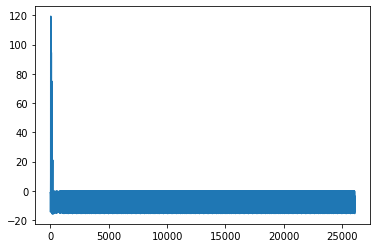

In [10]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.show()